# Packages

In [2]:
import freenect
import pylibfreenect2
import cv2
import numpy as np

import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import animation, rc
rc('animation', html='jshtml')

from collections import deque
import os
from tqdm.notebook import tqdm
from numba import njit, prange
from behavior_functions import *
import tifffile as tiff
import sys

from scipy.ndimage import median_filter

# Record video and depth with Kinect

In [1]:
import numpy as np
import cv2
import os
import time
from pylibfreenect2 import Freenect2, SyncMultiFrameListener
from pylibfreenect2 import FrameType, Registration, Frame
from pylibfreenect2 import OpenCLPacketPipeline
from pylibfreenect2 import OpenGLPacketPipeline



def record_video_kinectv2(folder_path, duration, acq_freq=30, overwrite=False):
    if not overwrite:
        if os.path.exists(os.path.join(folder_path, 'video.avi')):
            raise OSError('Oops, .avi video file already exists and overwrite arg set to False.')
        if os.path.exists(os.path.join(folder_path, 'depth.avi')):
            raise OSError('Oops, .avi depth file already exists and overwrite arg set to False.')

    fn = Freenect2()
    num_devices = fn.enumerateDevices()
    if num_devices == 0:
        print("No device connected!")
        return

    pipeline = OpenGLPacketPipeline()
    serial = fn.getDeviceSerialNumber(0)
    device = fn.openDevice(serial, pipeline=pipeline)

    listener = SyncMultiFrameListener(FrameType.Color | FrameType.Ir | FrameType.Depth)

    # Register listeners
    device.setColorFrameListener(listener)
    device.setIrAndDepthFrameListener(listener)

    device.start()

    # Prepare to save the video and depth
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video_out = cv2.VideoWriter(os.path.join(folder_path, 'video.avi'), fourcc, acq_freq, (1920, 1080))
    depth_out = cv2.VideoWriter(os.path.join(folder_path, 'depth.avi'), fourcc, acq_freq, (512, 424))

    start_time = time.time()

    while time.time() - start_time < duration:
        frames = listener.waitForNewFrame()

        color_frame = frames["color"]
        depth_frame = frames["depth"]

        # Convert color frame
        color_array = color_frame.asarray()[:, :, :3]

        # Process depth frame
        depth_array = depth_frame.asarray().astype(np.uint16)
        depth_array = np.right_shift(depth_array, 2)
        depth_array = cv2.convertScaleAbs(depth_array, alpha=(255.0 / 2047.0))
        depth_array_3ch = cv2.cvtColor(depth_array, cv2.COLOR_GRAY2RGB)

        # Resize color to match depth height
        color_resized = cv2.resize(color_array, (depth_array_3ch.shape[1], depth_array_3ch.shape[0]))

        # Concatenate color and depth images horizontally
        horizontal_image = np.hstack((depth_array_3ch, color_resized))

        # Show both images in a single window
        cv2.imshow('Depth & Video', horizontal_image)

        video_out.write(color_array)
        depth_out.write(depth_array_3ch)

        cv2.waitKey(1)

        listener.release(frames)

    video_out.release()
    depth_out.release()

    device.stop()
    device.close()

    cv2.destroyAllWindows()

    print('Done!')

    return None

In [2]:
import numpy as np
import cv2
import os
import time
from pylibfreenect2 import Freenect2, SyncMultiFrameListener
from pylibfreenect2 import FrameType
from pylibfreenect2 import OpenGLPacketPipeline

def record_video_kinectv2_v2(folder_path, duration, acq_freq=30, overwrite=False):
    if not overwrite:
        if os.path.exists(os.path.join(folder_path, 'video.avi')):
            raise OSError('Oops, .avi video file already exists and overwrite arg set to False.')
        if os.path.exists(os.path.join(folder_path, 'depth.avi')):
            raise OSError('Oops, .avi depth file already exists and overwrite arg set to False.')

    fn = Freenect2()
    num_devices = fn.enumerateDevices()
    if num_devices == 0:
        print("No device connected!")
        return

    pipeline = OpenGLPacketPipeline()
    serial = fn.getDeviceSerialNumber(0)
    device = fn.openDevice(serial, pipeline=pipeline)
    listener = SyncMultiFrameListener(FrameType.Color | FrameType.Depth)
    device.setColorFrameListener(listener)
    device.setIrAndDepthFrameListener(listener)
    device.start()
    
    frames = listener.waitForNewFrame()
    ref_color_frame = frames["color"]
    color_height, color_width, _ = ref_color_frame.asarray().shape
    new_height = 424
    aspect_ratio = color_width / color_height
    new_width = int(new_height * aspect_ratio)
    listener.release(frames)

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video_out = cv2.VideoWriter(os.path.join(folder_path, 'video.avi'), fourcc, acq_freq, (new_width, new_height))
    depth_out = cv2.VideoWriter(os.path.join(folder_path, 'depth.avi'), fourcc, acq_freq, (512, 424))

    start_time = time.time()
    last_frame_time = start_time
    frame_interval = 1.0 / acq_freq
    last_video_time = start_time

    while time.time() - start_time < duration:
        current_time = time.time()
        if current_time - last_frame_time < frame_interval:
            continue

        frames = listener.waitForNewFrame()
        color_frame = frames["color"]
        depth_frame = frames["depth"]

        color_array = color_frame.asarray()[:, :, :3]
        color_resized = cv2.resize(color_array, (new_width, new_height))
        depth_array = depth_frame.asarray().astype(np.uint16)
        depth_array = np.right_shift(depth_array, 2)
        depth_array = cv2.convertScaleAbs(depth_array, alpha=(255.0 / 2047.0))
        depth_array_3ch = cv2.cvtColor(depth_array, cv2.COLOR_GRAY2RGB)

        horizontal_image = np.hstack((depth_array_3ch, color_resized))


        cv2.imshow('Depth & Video', horizontal_image)
    


        video_out.write(color_resized)
        depth_out.write(depth_array_3ch)

        cv2.waitKey(1)
        listener.release(frames)
        last_frame_time = current_time

    video_out.release()
    depth_out.release()
    device.stop()
    device.close()
    cv2.destroyAllWindows()
    print('Done!')

    return None

In [8]:
record_video_kinectv2_v2(folder_path = '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S10/M213', duration = 630)

[Info] [Freenect2Impl] enumerating devices...
[Info] [Freenect2Impl] 1 usb devices connected
[Info] [Freenect2Impl] found valid Kinect v2 @20:21 with serial 010994543747
[Info] [Freenect2Impl] found 1 devices
[Info] [Freenect2DeviceImpl] opening...
[Info] [Freenect2DeviceImpl] transfer pool sizes rgb: 20*16384 ir: 4*128*33792
[Info] [Freenect2DeviceImpl] opened
[Info] [Freenect2DeviceImpl] starting...
[Info] [Freenect2DeviceImpl] submitting rgb transfers...
[Info] [Freenect2DeviceImpl] submitting depth transfers...
[Info] [Freenect2DeviceImpl] started
[Info] [DepthPacketStreamParser] 5 packets were lost
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [OpenGLDepthPacketProcessor] avg. time: 13.2525ms -> ~75.4576Hz
[Info] [VTRgbPacketProcessor] avg. time: 12.4697ms -> ~80.1942Hz
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.12605ms -> ~109.576Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.7216ms -> ~85.3125Hz
[Info] [Ope

[Info] [VTRgbPacketProcessor] avg. time: 11.6175ms -> ~86.0773Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.9999ms -> ~111.112Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.4712ms -> ~87.1752Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.23943ms -> ~108.232Hz
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [VTRgbPacketProcessor] avg. time: 11.5805ms -> ~86.3524Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.17925ms -> ~108.941Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5526ms -> ~86.5606Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.28853ms -> ~107.66Hz
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [VTRgbPacketProcessor] avg. time: 11.5487ms -> ~86.5901Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.11135ms -> ~109.753Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5932ms -> ~86.2575Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.33299ms -> ~107.147Hz
[Info] [DepthPacketStreamPa

[Info] [VTRgbPacketProcessor] avg. time: 11.5304ms -> ~86.7271Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.78506ms -> ~113.83Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5518ms -> ~86.5668Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.84039ms -> ~113.117Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5722ms -> ~86.4138Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.81967ms -> ~113.383Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5409ms -> ~86.6485Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.95378ms -> ~111.685Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5794ms -> ~86.3606Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.96631ms -> ~111.529Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5764ms -> ~86.3827Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.02761ms -> ~110.771Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5649ms -> ~86.4686Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.09099ms -> ~109.999Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.4811m

[Info] [VTRgbPacketProcessor] avg. time: 11.6046ms -> ~86.1727Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.13768ms -> ~109.437Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.6587ms -> ~85.7731Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.03309ms -> ~110.704Hz
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [VTRgbPacketProcessor] avg. time: 11.7087ms -> ~85.4066Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 9.06417ms -> ~110.324Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.7265ms -> ~85.2767Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.87979ms -> ~112.615Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.7212ms -> ~85.3156Hz
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.93872ms -> ~111.873Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.5982ms -> ~86.2202Hz
[Info] [DepthPacketStreamParser] 1 packets were lost
[Info] [OpenGLDepthPacketProcessor] avg. time: 8.96061ms -> ~111.6Hz
[Info] [VTRgbPacketProcessor] avg. time: 11.6488ms -> ~85.8461Hz
[Info] [OpenGLD

In [11]:
record_video(folder_path='/Users/vincentchouinard/Documents/Maitrise/Behavior/NOR_24h_9avril/Testing/NOR_OBRM_M50', duration=120)

loop starts
Done!


Got cancelled transfer, but we didn't request it - device disconnected?
USB camera marked dead, stopping streams
send_cmd: Output control transfer failed (-99)
write_register: send_cmd() returned -99
send_cmd: Output control transfer failed (-99)
write_register: send_cmd() returned -99


# Reads avi files

In [28]:
# Call the function to open and display the .avi file
view_avi('/Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/video.avi')

# Camera characterization
Framerate is 32 hz but once in every 30 frames, there's a frame that takes 0.048 secs to be aquired instead of 0.032

# Pipeline

In [15]:
video_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/video.avi"
crop_and_save(video_path)

depth_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/depth.avi"
crop_and_save(depth_path)

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/cropped_depth.avi


In [5]:
split = os.path.split(video_path)
cropped_video_path = split[0] + "/cropped_" + split[1]
video_substract_background(cropped_video_path, temp_filt = "mean")

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/background_substracted_cropped_video.avi


### Étape Fiji:


1. Ouvrir background_substracted_video.avi sur Fiji
2. Run la macro "_binary_script_fiji.ijm". Les étapes sont détaillées dans le script java. Sauvegarder.
3. Vérifier rapidement mask_video.

In [4]:
split = os.path.split(video_path)
mask_video_path = split[0] + "/mask_video.avi"
centroids = compute_centroids(mask_video_path)
filtered_centroids = centroid_mean_filter(centroids, 23)

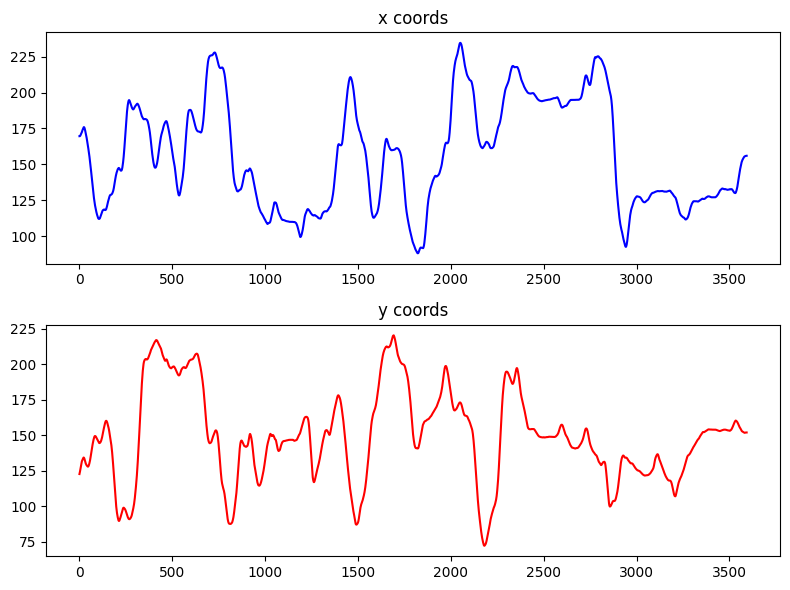

In [5]:
centroid_plot(filtered_centroids)

In [6]:
animate_trajectory(cropped_video_path, filtered_centroids, save=False)

/opt/anaconda3/envs/kinect/lib/python3.8/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


# R&D for depth

In [12]:
def binarize(stack, threshold):

    # Create a boolean mask for values outside the band
    data = np.copy(stack)
    
    mask = data > threshold
    
    # Set the values outside the band to zero
    data[mask] = 1
    data[~mask] = 0
    
    return data

def intensity_bandpass_filter(data, bandpass):
    
    lower_threshold, upper_threshold = bandpass[0], bandpass[1]
    # Create a boolean mask for values outside the band
    mask = (data < lower_threshold) | (data > upper_threshold)
    
    # Set the values outside the band to zero
    data[mask] = 0
    
    return data

def plot_histogram(data, xlim=(50,100)):
    """
    Plot a histogram for a 2D array focusing on values between xlim.
    
    Parameters:
    - data: 2D numpy array
    - xlim: Tuple representing the lower and upper range of the x-axis (e.g., (10, 150)). Default is (0, 256).
    """

    # Extract the values of interest from the 2D array
    values_of_interest = data[(data > xlim[0]) & (data < xlim[1])].ravel()
    
    # The number of bins should be the difference in xlim values for integer values
    bins = xlim[1] - xlim[0]
    
    plt.hist(values_of_interest, bins=bins, color='blue', alpha=0.7, range=xlim)
    plt.title('Histogram of Values of Interest')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    
    plt.xlim(xlim[0], xlim[1])  # setting x-axis limits
    plt.grid(True)
    plt.show()
    
import cv2
import os

def rescale_video(target_video_path, reference_video_path):
    """
    Rescale the target video to match the dimensions of the reference video.
    
    Parameters:
    - target_video_path: the path to the video you want to resize.
    - reference_video_path: the path to the reference video.
    - output_video_path: the path to save the resized video.
    """
    
    def get_video_ref_details(video_path):
        
        cap = cv2.VideoCapture(video_path)
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return fps, width, height, num_frames
    

    # Get dimensions of the reference video
    ref_fps, ref_width, ref_height, num_frames = get_video_ref_details(reference_video_path)

    # Open target video
    cap = cv2.VideoCapture(target_video_path)
    
    # Video Writer setup
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video_name = os.path.split(target_video_path)[1]
    output_video_path = os.path.join(os.path.dirname(video_path), "resized_" + video_name)
    out = cv2.VideoWriter(output_video_path, fourcc, ref_fps, (ref_width, ref_height))
    
    for i in tqdm(range(num_frames)):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame
        resized_frame = cv2.resize(frame, (ref_width, ref_height))
        out.write(resized_frame)

    # Cleanup
    cap.release()
    out.release()
    print(f"Resized video saved to {output_video_path}")

In [27]:
depth_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/resized_cropped_depth.avi"
mask_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/behav_M34_18sept/mask_video.avi"
depth = avi_to_array(depth_path)
mask = avi_to_array(mask_path)

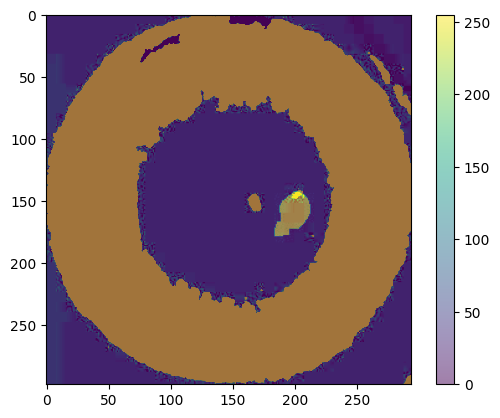

In [8]:
plt.imshow(depth[0], vmin=75, vmax = 100)
plt.imshow(mask[0], alpha=0.5)
plt.colorbar()
plt.show()

In [9]:
binary_mask = binarize(mask, 100)
depth_mask = depth*binary_mask

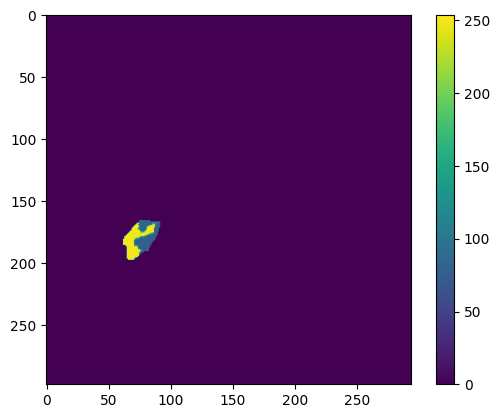

In [10]:
plt.imshow(depth_mask[1414])
plt.colorbar()

In [13]:
filtered_depth_mask = intensity_bandpass_filter(depth_mask, [60,100])

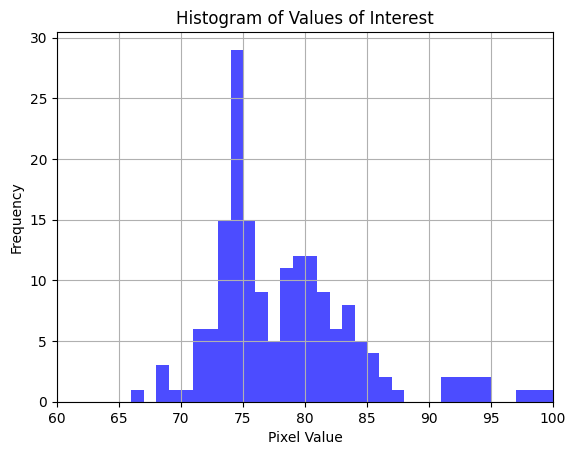

In [26]:
plot_histogram(filtered_depth_mask[515], xlim=(60,100))

In [30]:
def temporal_median_filter(stack, kernel_size=3):

    # The size parameter for median_filter is given as a tuple. 
    # In this case, we only want to filter across the time axis, 
    # so we provide kernel_size for that axis and 1 for the spatial axes.
    
    size = (kernel_size, 1, 1)
    filtered_stack = median_filter(stack, size=size)
    
    return filtered_stack

In [32]:
filtered_depth = temporal_median_filter(depth)
binary_mask = binarize(mask, 100)
depth_mask = filtered_depth*binary_mask

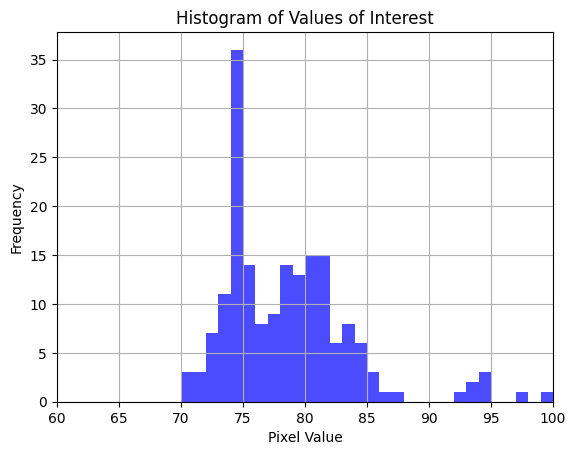

In [33]:
plot_histogram(depth_mask[515], xlim=(60,100))

### Ok so temporal median filters help, now i should threshold for mouse limits and get the max value !

# Figuring out transform parameters between video and depth space

In [90]:
video.shape

(424, 752, 3)

In [89]:
trsfmd_frame.shape

(424, 512)

# That's kinect v2's affine transform

(0.0, 424.0)

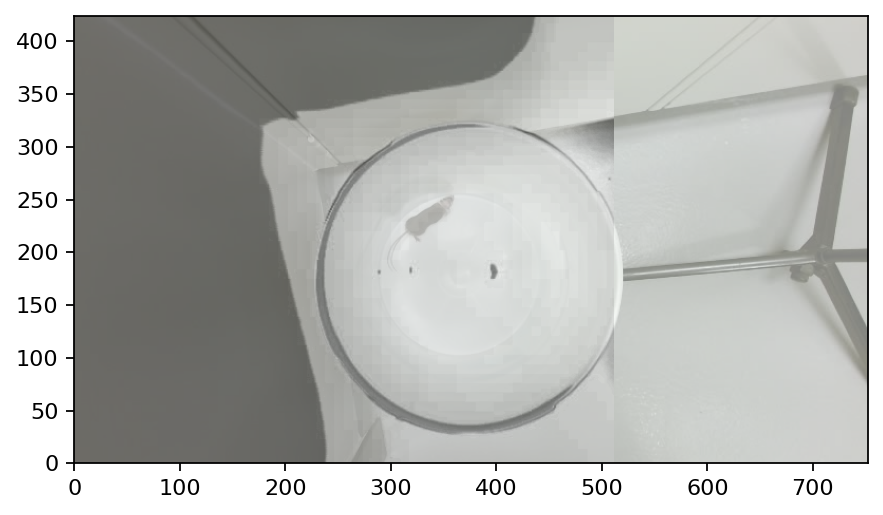

In [4]:
# Given values
frame = tiff.imread("/Users/vincentchouinard/Desktop/depth.tif")[:,:,0]
video = tiff.imread("/Users/vincentchouinard/Desktop/video.tif")



#s = 1./1.10195914
s = 1
#affine_matrix = np.array([[s, 0.        ], [0., s]])
#offset = np.array([19.86813022, 41.77996883])
affine_matrix = np.array([[1.11, 0.],[0., 1.12]])
offset = np.array([132., -22])

# Adjusting for cv2
affine_matrix_cv2 = np.hstack([affine_matrix, offset.reshape(-1, 1)])
trsfmd_frame = cv2.warpAffine(frame, affine_matrix_cv2, (frame.shape[1], frame.shape[0]))

fig,ax = plt.subplots(dpi=160)
ax.imshow(video, alpha=0.5)
ax.imshow(trsfmd_frame, alpha=0.5, cmap='gray', vmin=0, vmax=30)

ax.set_xlim([0,752])
ax.set_ylim([0,424])


In [142]:
video.shape

(424, 752, 3)

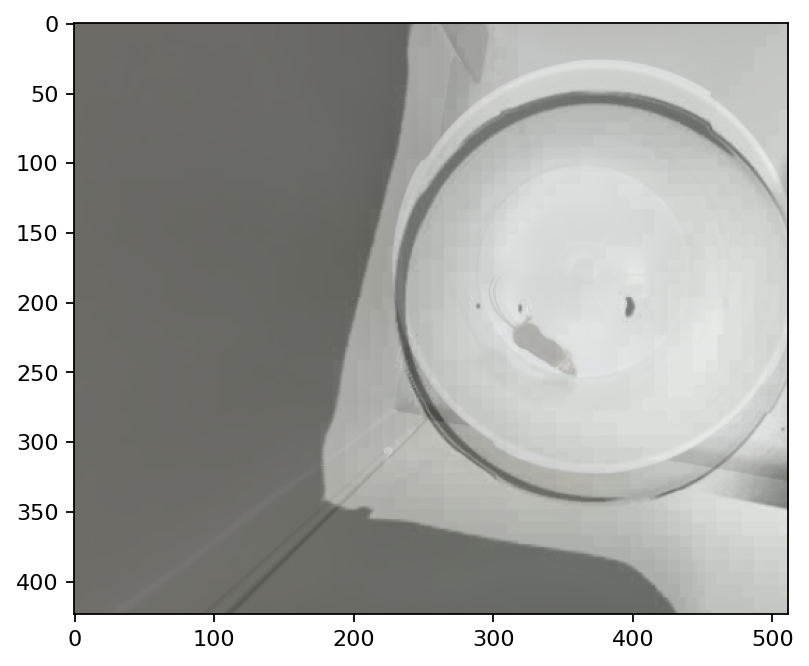

In [164]:
# Transformation parameters
affine_matrix = np.array([[1.11, 0.], [0., 1.12]])
offset = np.array([132., -62])

# Calculate new dimensions of the output image
height, width = frame.shape
new_width = width
new_height = height

# Adjust affine matrix for the offset to fit within new dimensions
offset_adjusted = offset.copy()
if offset[0] < 0:
    offset_adjusted[0] = 0
if offset[1] < 0:
    offset_adjusted[1] = 0

affine_matrix_cv2 = np.hstack([affine_matrix, offset_adjusted.reshape(-1, 1)])

# Transform the frame
trsfmd_frame = cv2.warpAffine(frame, affine_matrix_cv2, (new_width, new_height))

fig,ax = plt.subplots(dpi=160)

ax.imshow(video, alpha=0.5)
ax.imshow(trsfmd_frame, alpha=0.5, cmap='gray', vmin=0, vmax=30)



In [9]:
video.shape

(424, 752, 3)

In [10]:
trsfmd_frame.shape

(424, 644)

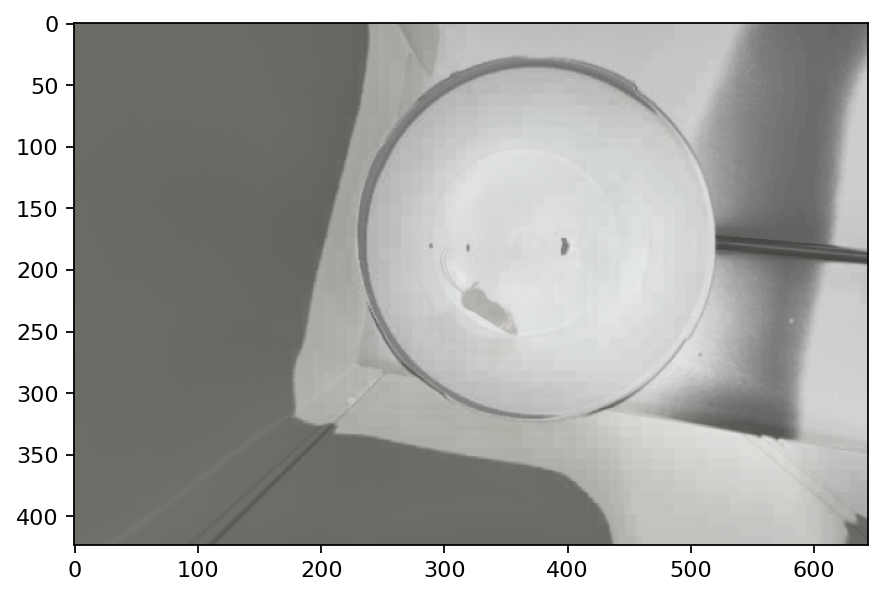

In [8]:
#s = 1./1.10195914
s = 1
#affine_matrix = np.array([[s, 0.        ], [0., s]])
#offset = np.array([19.86813022, 41.77996883])
affine_matrix = np.array([[1.11, 0.],[0., 1.12]])
offset = np.array([132, -22])

# Adjusting for cv2
affine_matrix_cv2 = np.hstack([affine_matrix, offset.reshape(-1, 1)])
trsfmd_frame = cv2.warpAffine(frame, affine_matrix_cv2, (frame.shape[1]+offset[0], frame.shape[0]))

fig,ax = plt.subplots(dpi=160)
ax.imshow(video, alpha=0.5)
ax.imshow(trsfmd_frame, alpha=0.5, cmap='gray', vmin=0, vmax=30)

#ax.set_xlim([0,752])
#ax.set_ylim([0,424])

(424, 644)

# Ok y manque juste un peu d'ajustement pour new_width et new_height pour que y'ait pas d'infos qui sont perdues dans depth, pis ensuite on skirt ça dans behavior preprocessing pis on check le depthmask pis toute ! 

# Multiple datasets analysis 

# Dataset_list

In [4]:
def identify_files(path, keywords):
    items = os.listdir(path)
    files = []
    for item in items:
        if all(keyword in item for keyword in keywords):
            files.append(item)
    return files

In [5]:
# list of folders in which there are datasets
behavior_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior"
keywords = "BH"
behavior_sessions = identify_files(behavior_path, keywords)

# list of keywords associated to each folder
keywords = []
for i in range(len(behavior_sessions)):
    keywords.append(behavior_sessions[i][-2:]) # Creates keywords in good order ( Il faut que 'S1' ou 'S2' soit à
                                                # la fin du string )

# Data cropping
dataset_list = []
for i in range(len(behavior_sessions)):
    dataset_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/" + behavior_sessions[i]
    single_session_dataset_paths = identify_files(dataset_path, keywords[i])
    for i in range(len(single_session_dataset_paths)):
        
        dataset_list.append(dataset_path + "/" + single_session_dataset_paths[i])

# Creates background_list

In [4]:
from pathlib import Path

# Depends on name structure. Folders need to be of stucture "BH_MXX_SX" where MXX is the mouse name and SX is the
# session.

background_list = []
for i in range(len(dataset_list)):
    data_name = dataset_list[i].split('/')[-1]
    Path_name = Path(dataset_list[i])
    parent_path = Path_name.parent.absolute()
    mouse_name, session_id = data_name.split('_')[-2], data_name.split('_')[-1]
    mouse_number = mouse_name[-2:]
    background_path = identify_files(parent_path, keywords=['background', mouse_number])
    if len(background_path) == 0:
        bg_list = [str(parent_path) + '/BH_background']
    else:
        bg_list = [str(parent_path) + '/' + background_path[0]]
    for i in range(len(bg_list)):
        background_list.append(bg_list[i])

# Background substraction

In [64]:
# Function is on Pycharm

import numpy as np
import cv2

def substract_background(video_path, background_path):
    
    video_path += "/video.avi"
    background_path += "/video.avi"
    
    bg_stack = avi_to_array(background_path)
    background = np.mean(bg_stack, axis=0).astype(np.uint8)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open input video file.")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video_name = os.path.split(video_path)[1]
    output_video_path = os.path.join(os.path.dirname(video_path), "bg_sub_" + video_name)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height), isColor=False)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        background_substracted_frame = cv2.absdiff(frame_gray, background)
        blurred_bsf = cv2.GaussianBlur(background_substracted_frame, (3, 3), 1)

        out.write(blurred_bsf)

    cap.release()
    out.release()
    print(f"Output video saved to {output_video_path}")

In [ ]:
for i in tqdm(range(len(dataset_list))):
    substract_background(dataset_list[i], background_list[i])

# Get rectangles to loop over crop function

In [5]:
def get_first_frame_and_count(file_path):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open file {file_path}.")
            return None, None
        ret, first_frame = cap.read()
        if not ret:
            print("Error: Could not read the first frame.")
            cap.release()
            return None, None
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return first_frame, total_frames
    
def select_rectangle(image):
        cv2.namedWindow('Select ROI')
        cv2.imshow('Select ROI', image)
        rectangle = cv2.selectROI('Select ROI', image)
        cv2.waitKey(10)
        cv2.destroyAllWindows()
        cv2.waitKey(10)
        return rectangle

def get_rectangles(dataset_list):
    
    # Operations
    rectangle_list = []
    for i in range(len(dataset_list)):
        video_path = os.path.join(dataset_list[i], "video.avi")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print("Error: Could not open input video file.")
            return
        first_frame, _ = get_first_frame_and_count(video_path)
        rectangle = select_rectangle(first_frame)
        rectangle_list.append(rectangle)
        
    return rectangle_list

In [ ]:
# Getting rectangles
rectangle_list = get_rectangles(dataset_list)

# Crop video and depth 

In [6]:
def crop_video_and_depth(behavior_folder, rectangle=None):

    # GET FIRST FRAME AND COUNT IS OUT OF THE FUNCTION CAUSE ITS USED ELSEWHERE
#     def get_first_frame_and_count(file_path):
#         cap = cv2.VideoCapture(file_path)
#         if not cap.isOpened():
#             print(f"Error: Could not open file {file_path}.")
#             return None, None
#         ret, first_frame = cap.read()
#         if not ret:
#             print("Error: Could not read the first frame.")
#             cap.release()
#             return None, None
#         total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#         cap.release()
#         return first_frame, total_frames
    
    # USED FOR GET_RECTANGLES SO OUT OF FUNCTION
#     def select_rectangle(image):
#         cv2.namedWindow('Select ROI')
#         cv2.imshow('Select ROI', image)
#         rectangle = cv2.selectROI('Select ROI', image)
#         cv2.waitKey(10)
#         cv2.destroyAllWindows()
#         cv2.waitKey(10)
#         return rectangle

    def crop_image(image, rectangle):
        return image[int(rectangle[1]):int(rectangle[1] + rectangle[3]), int(rectangle[0]):int(rectangle[0] + rectangle[2])]

    def process_video(file_path, output_path, rectangle):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open file {file_path}.")
            return
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_path, fourcc, 31.0, (rectangle[2], rectangle[3]))
        for _ in tqdm(range(total_frames), desc=f"Processing {os.path.basename(output_path)}"):
            ret, frame = cap.read()
            if not ret:
                break
            cropped_frame = crop_image(frame, rectangle)
            out.write(cropped_frame)
        cap.release()
        out.release()
        print(f"Output saved to {output_path}")

    def process_depth(file_path, output_path, rectangle):
        affine_matrix = np.array([[0.92, 0.], [0., 0.92]])
        offset = np.array([13., 34.])
        affine_matrix_cv2 = np.hstack([affine_matrix, offset.reshape(-1, 1)])
        
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open file {file_path}.")
            return
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        out = cv2.VideoWriter(output_path, fourcc, 30.0, (rectangle[2], rectangle[3]))
        for _ in tqdm(range(total_frames), desc=f"Processing {os.path.basename(output_path)}"):
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.warpAffine(frame, affine_matrix_cv2, (frame.shape[1], frame.shape[0]))
            cropped_frame = crop_image(frame, rectangle)
            out.write(cropped_frame)
        cap.release()
        out.release()
        print(f"Output saved to {output_path}")

    video_path = os.path.join(behavior_folder, "bg_sub_video.avi")
    depth_path = os.path.join(behavior_folder, "depth.avi")

    first_frame, total_frames_video = get_first_frame_and_count(video_path)
    _, total_frames_depth = get_first_frame_and_count(depth_path)
    if first_frame is None:
        return

    if rectangle is None:
        roi = select_rectangle(first_frame)
        print(roi)
    else:
        roi = rectangle

    output_video_path = os.path.join(os.path.dirname(video_path), "cropped_video.avi")
    output_depth_path = os.path.join(os.path.dirname(depth_path), "cropped_depth.avi")

    process_video(video_path, output_video_path, roi)
    process_depth(depth_path, output_depth_path, roi)

In [ ]:
for i in tqdm(range(len(dataset_list))):
    if os.path.exists(dataset_list[i] + "/cropped_video.avi"):
        continue
    else:
        crop_video_and_depth(dataset_list[i], rectangle=rectangle_list[i])

In [7]:
def binarize_video(data_path):
    file_path = os.path.join(data_path, "cropped_video.avi")
    output_path = os.path.join(data_path, "mask_video.tif")
    
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error: Could not open file {file_path}.")
        return
    
    def get_first_frame_and_count(file_path):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            print(f"Error: Could not open file {file_path}.")
            return None, None
        ret, first_frame = cap.read()
        if not ret:
            print("Error: Could not read the first frame.")
            cap.release()
            return None, None
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return first_frame, total_frames
    
    def collect_pixel_values(file_path, skip_frames=1):
        cap2 = cv2.VideoCapture(file_path)
        pixel_values = []

        total_frames = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))

        for i in tqdm(range(0, total_frames, skip_frames)):
            cap2.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap2.read()
            if not ret:
                break

            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            pixel_values.extend(gray_frame.flatten())

        cap2.release()
        return pixel_values
    
    pixel_values = collect_pixel_values(file_path, skip_frames=30)
    threshold_value = int(np.percentile(pixel_values, 99.1))
    print(threshold_value)
    
    first_frame, total_frames = get_first_frame_and_count(file_path)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    
    with tiff.TiffWriter(output_path) as tif:
        for i in tqdm(range(total_frames), desc=f"Binarizing {os.path.basename(output_path)}"):
            ret, frame = cap.read()
            if not ret:
                break

            # Convert to grayscale
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Apply threshold
            _, binary_mask = cv2.threshold(gray_frame, threshold_value, 255, cv2.THRESH_BINARY)
            
            # Erode 2 times
            eroded_mask = cv2.erode(binary_mask, kernel, iterations=2)

            # Dilate 5 times
            dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=5)

            # Erode 3 times
            final_mask = cv2.erode(dilated_mask, kernel, iterations=3)

            # Convert to binary (0s and 1s)
            final_mask = (final_mask // 255).astype(np.uint8)

            tif.save(final_mask)
    
    cap.release()
    print(f"Output saved to {output_path}")

In [52]:
for i in tqdm(range(len(s2_list))):
    binarize_video(s2_list[i])

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

119


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

/var/folders/w6/s9qjh5156jg5p8dh9sd4bysr0000gn/T/ipykernel_4547/1897668416.py:74: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tif.save(final_mask)


Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

90


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M40_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

79


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M35_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

59


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M41_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

62


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

141


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2/mask_video.tif


  0%|          | 0/560 [00:00<?, ?it/s]

87


Binarizing mask_video.tif:   0%|          | 0/16774 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M39_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

129


Binarizing mask_video.tif:   0%|          | 0/17982 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

82


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M38_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

58


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M42_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

73


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M37_S2/mask_video.tif


  0%|          | 0/600 [00:00<?, ?it/s]

74


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2/mask_video.tif


In [2]:
# def compute_centroids(mask_stack_path):
#     # Read the TIFF stack
#     stack = tiff.imread(mask_stack_path)
    
#     # Get the number of frames in the stack
#     n_frames = stack.shape[0]

#     # Initialize an array to store the centroid coordinates
#     centroids = np.zeros((n_frames, 2), dtype=np.int16)

#     # Process the stack frame by frame
#     for i in tqdm(range(n_frames)):
#         frame = stack[i]


#         # Find the contours in the binary mask
#         contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#         # Compute the centroid for the largest contour
#         if contours:
#             largest_contour = max(contours, key=cv2.contourArea)
#             M = cv2.moments(largest_contour)
#             if M["m00"] != 0:
#                 cx = int(M['m10'] / M['m00'])
#                 cy = int(M['m01'] / M['m00'])
#                 centroids[i, :] = [cx, cy]

#     return centroids
def compute_centroids(mask_stack_path):
    with tiff.TiffFile(mask_stack_path) as tif:
        # Get the number of frames in the stack
        n_frames = len(tif.pages)
        
        # Initialize an array to store the centroid coordinates
        centroids = np.zeros((n_frames, 2), dtype=np.int16)
        
        # Process the stack frame by frame
        for i in tqdm(range(n_frames)):
            # Read the current frame
            frame = tif.pages[i].asarray()

            # Find the contours in the binary mask
            contours, _ = cv2.findContours(frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Compute the centroid for the largest contour
            if contours:
                largest_contour = max(contours, key=cv2.contourArea)
                M = cv2.moments(largest_contour)
                if M["m00"] != 0:
                    cx = int(M['m10'] / M['m00'])
                    cy = int(M['m01'] / M['m00'])
                    centroids[i, :] = [cx, cy]
                    
    return centroids

In [3]:
def get_tiff_dimensions(file_path):
    with tiff.TiffFile(file_path) as tif:
        # Get the dimensions of the first image in the stack
        # (assuming all images in the stack have the same dimensions)
        height, width = tif.pages[0].shape[:2]
        
        # Get the number of frames in the stack
        n_frames = len(tif.pages)
        
    return n_frames, height, width

In [6]:
import pickle

def save_dict(file_path, data_dict):
    """
    Serialize and save a dictionary to a file using pickle.

    Args:
        file_path (str): The file path where the dictionary will be saved.
        data_dict (dict): The dictionary to be saved.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(data_dict, file)
        
def load_dict(file_path):
    """
    Load a dictionary from a file saved using pickle.

    Args:
        file_path (str): The file path of the saved dictionary.

    Returns:
        dict: The loaded dictionary.
    """
    with open(file_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

for i in tqdm(range(len(dataset_list))):
    
    data_dict = {}
    mask_path = dataset_list[i] + "/mask_video.tif"
    centroids = compute_centroids(mask_path)
    data_dict['xy_coordinates'] = centroids
    
    # Specify the file path where you want to save the dictionary
    file_path = dataset_list[i] + '/metadata.pkl'

    save_dict(file_path, data_dict)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17982 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17978 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17965 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17982 [00:00<?, ?it/s]

  0%|          | 0/17979 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/16774 [00:00<?, ?it/s]

  0%|          | 0/17982 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17980 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/17981 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

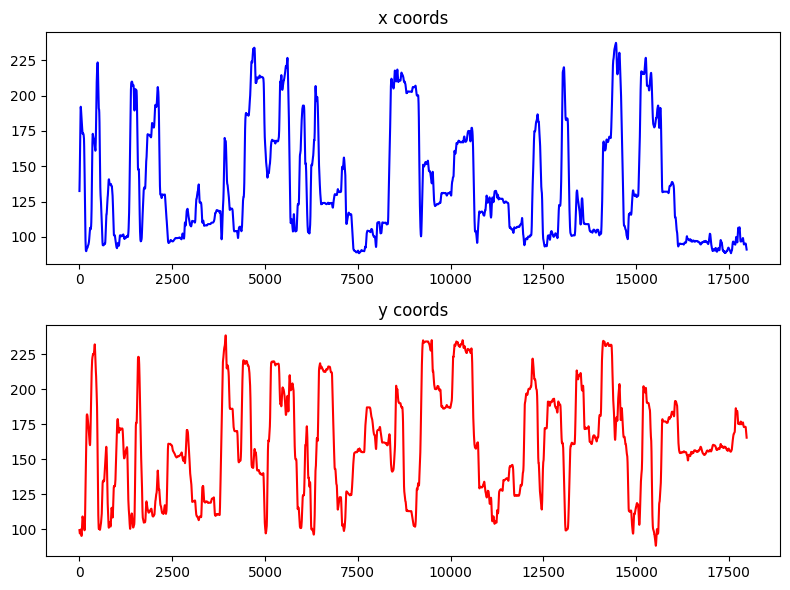

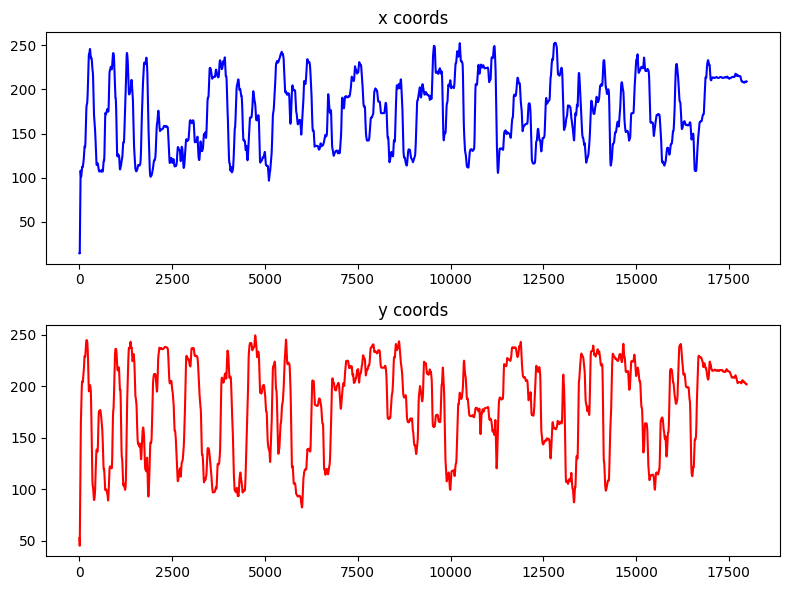

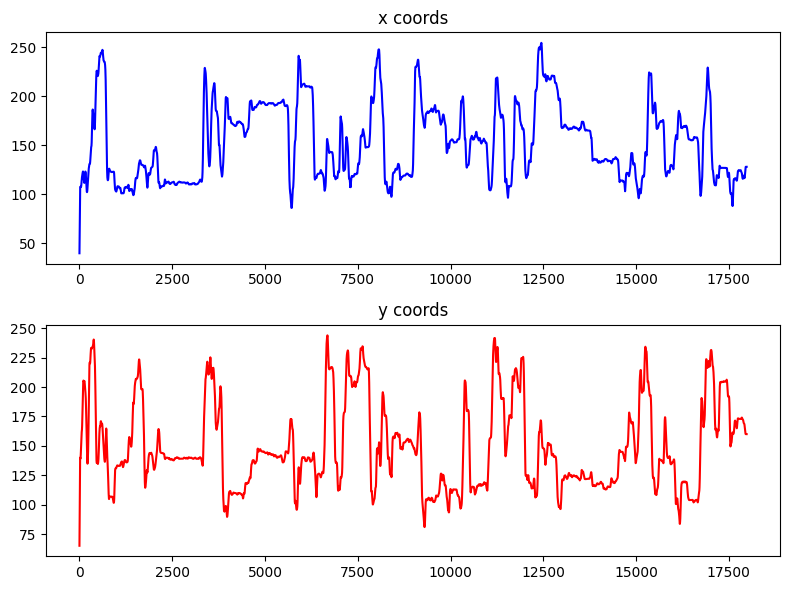

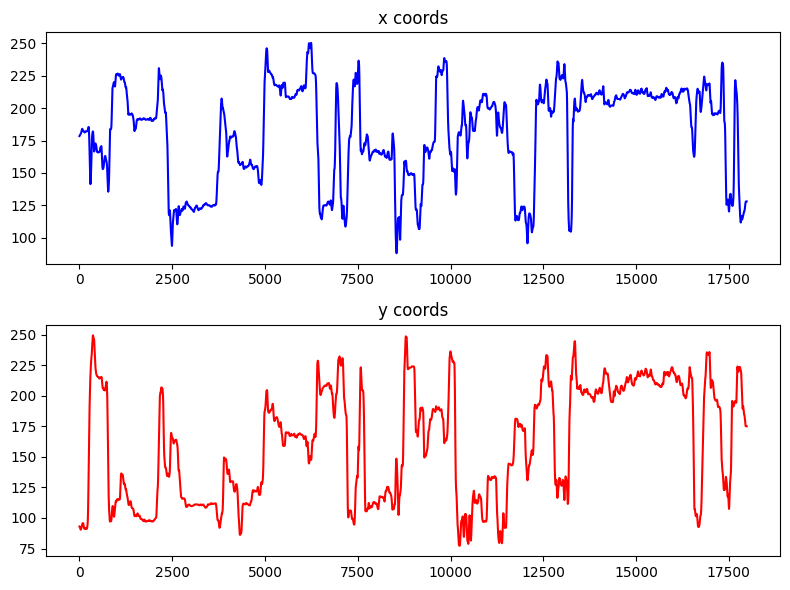

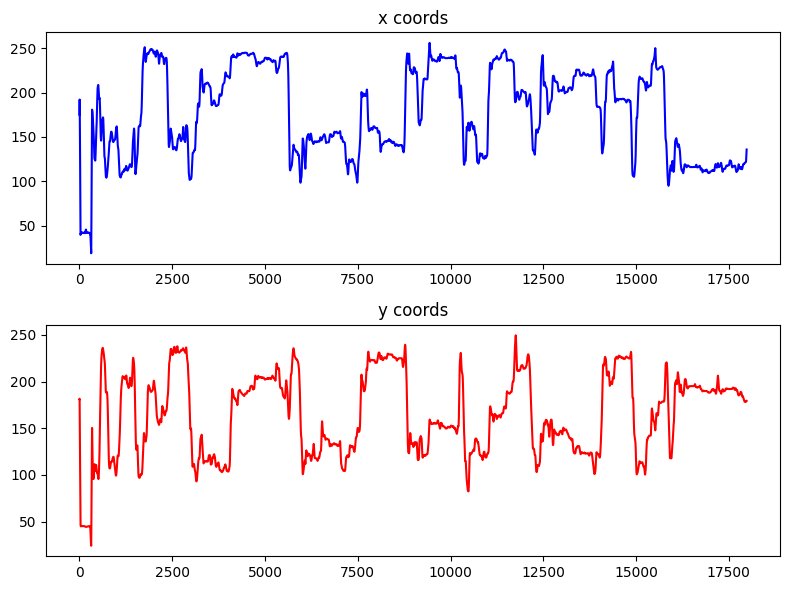

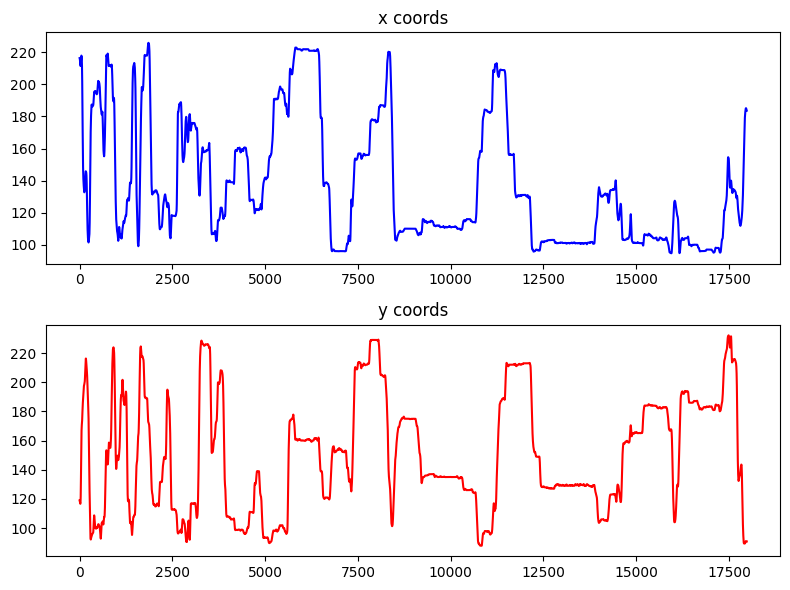

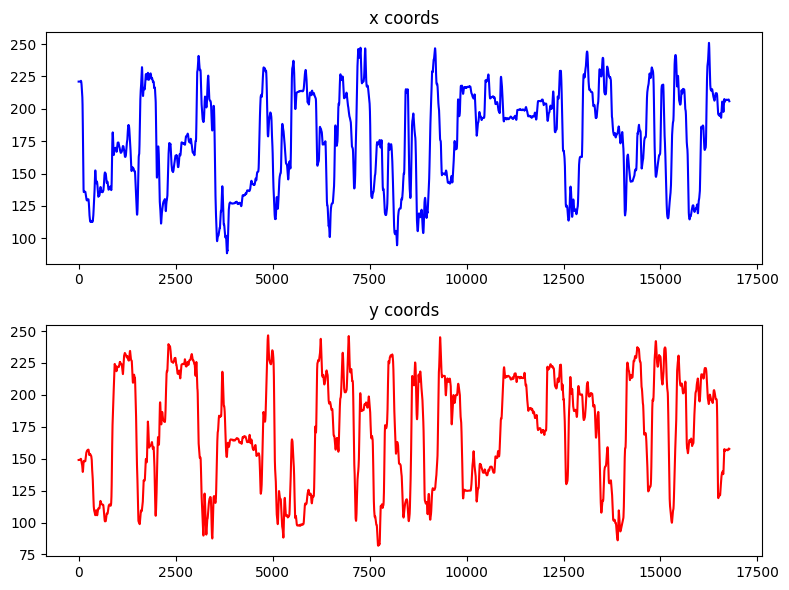

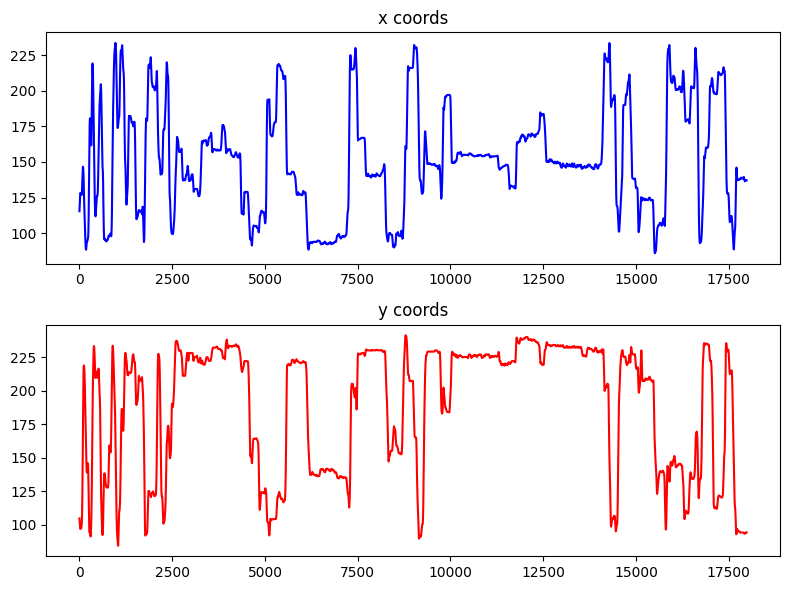

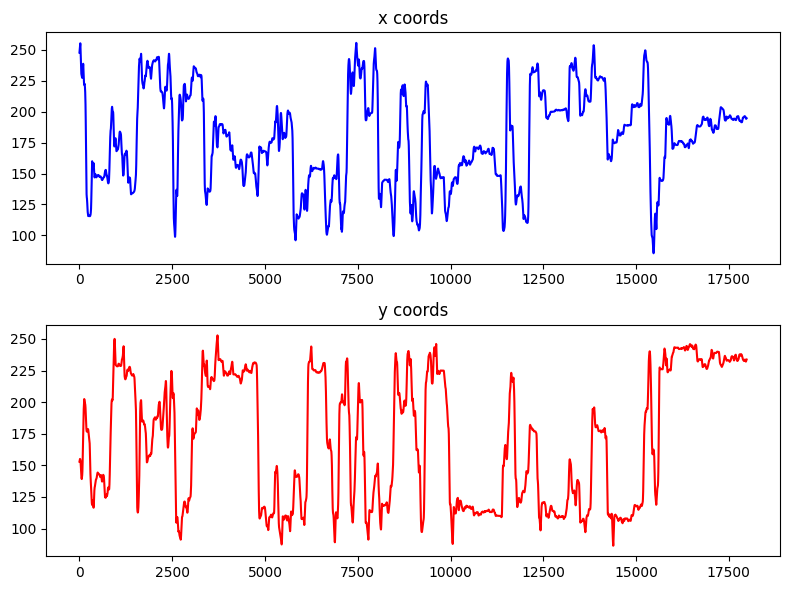

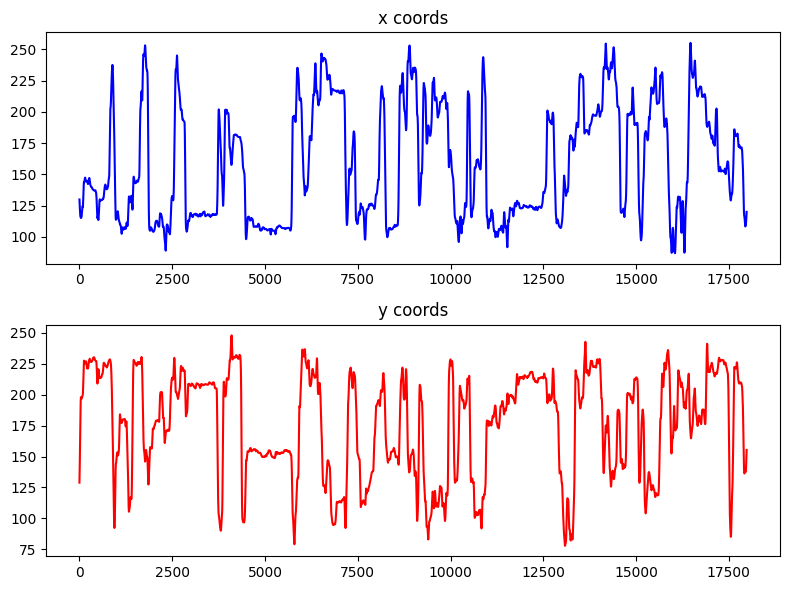

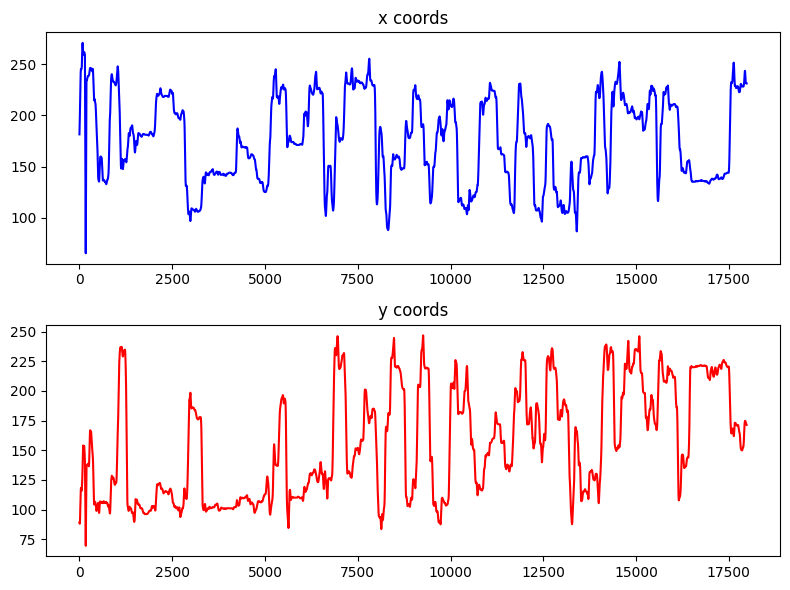

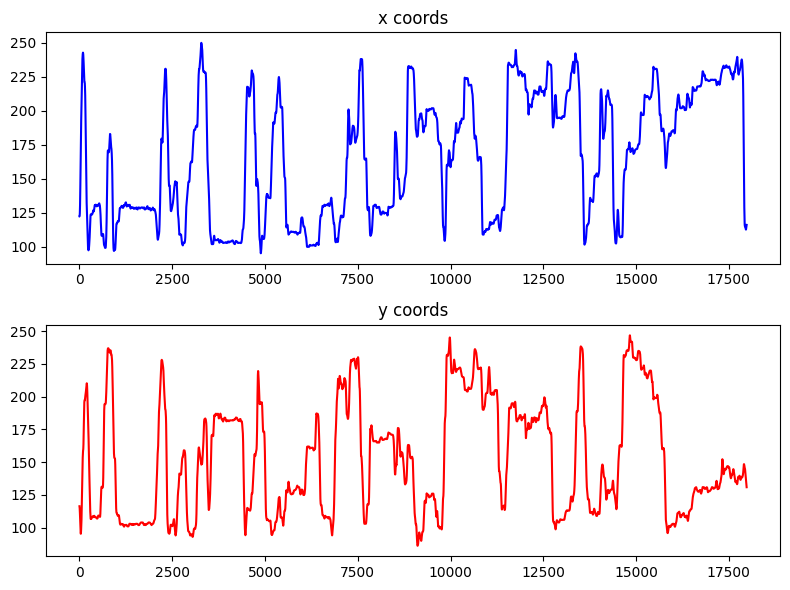

In [9]:
for i in tqdm(range(len(dataset_list))):
    if 'S2' in dataset_list[i]:
        data_dict = load_dict(dataset_list[i] + '/metadata.pkl')
        filtered = centroid_mean_filter(data_dict["xy_coordinates"], 23)
        centroid_plot(filtered)
    

In [4]:
def total_movement(coordinates):
    # Calculate the differences between consecutive coordinates
    differences = np.diff(coordinates.astype(np.float32()), axis=0)
    
    # Calculate the Euclidean distance for each pair of points
    distances = np.sqrt(np.sum(differences**2, axis=1))
    
    # Sum up the distances to get the total movement
    total_distance = np.sum(distances)
    
    return total_distance

In [12]:
dist_s1 = []
dist_s2 = []
dist_s3 = []
dist_s4 = []

for i in tqdm(range(len(dataset_list))):
    data_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    filtered = centroid_mean_filter(data_dict['xy_coordinates'][300:,:], 23)
    distance = total_movement(filtered)
    
    if "BH_S1" in dataset_list[i]:
        dist_s1.append(distance)
    elif "BH_S2" in dataset_list[i]:
        dist_s2.append(distance)
    elif "BH_S3" in dataset_list[i]:
        dist_s3.append(distance)
    elif "BH_S4" in dataset_list[i]:
        dist_s4.append(distance)

  0%|          | 0/46 [00:00<?, ?it/s]

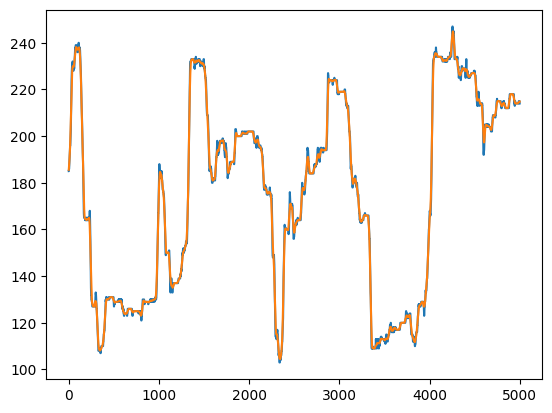

In [212]:
plt.plot(data_dict['xy_coordinates'][:,0])
plt.plot(filtered[:,0])

In [2]:
dist_M28 = []
dist_M29 = []
dist_M31 = []
dist_M33 = []
dist_M34 = []
dist_M35 = []
dist_M37 = []
dist_M38 = []
dist_M39 = []
dist_M40 = []
dist_M41 = []
dist_M42 = []

for i in tqdm(range(len(dataset_list))):
    data_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    #filtered = centroid_mean_filter(data_dict['xy_coordinates'], 23)
    filtered = data_dict
    distance = total_movement(filtered)
    
    if "M28" in dataset_list[i]:
        dist_M28.append(distance)
    elif "M29" in dataset_list[i]:
        dist_M29.append(distance)
    elif "M31" in dataset_list[i]:
        dist_M31.append(distance)
    elif "M33" in dataset_list[i]:
        dist_M33.append(distance)
    elif "M34" in dataset_list[i]:
        dist_M34.append(distance)
    elif "M35" in dataset_list[i]:
        dist_M35.append(distance)
    elif "M37" in dataset_list[i]:
        dist_M37.append(distance)
    elif "M38" in dataset_list[i]:
        dist_M38.append(distance)
    elif "M39" in dataset_list[i]:
        dist_M39.append(distance)
    elif "M40" in dataset_list[i]:
        dist_M40.append(distance)
    elif "M41" in dataset_list[i]:
        dist_M41.append(distance)
    elif "M42" in dataset_list[i]:
        dist_M42.append(distance)

NameError: name 'dataset_list' is not defined

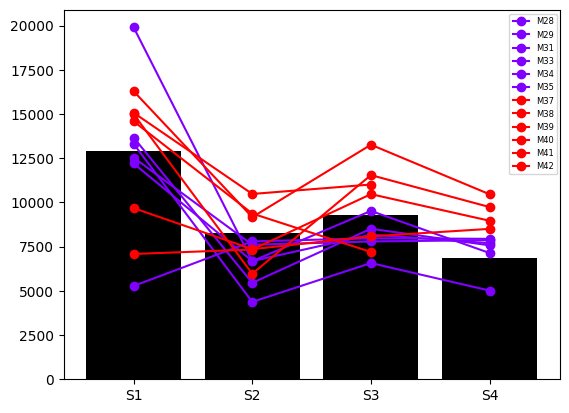

In [208]:
# Create subplots
fig, ax = plt.subplots()

# Define the number of colors
num_colors = 12

# Create a list of colors ranging from red to blue
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))

ax.bar(0,np.mean(dist_s1), color = 'black')
ax.bar(1,np.mean(dist_s2), color = 'black')
ax.bar(2,np.mean(dist_s3), color = 'black')
ax.bar(3,np.mean(dist_s4), color = 'black')
ax.plot([0,1,2,3], dist_M28, color = colors[0], marker='o', label= 'M28')
ax.plot([0,1,2,3], dist_M29, color = colors[0], marker='o', label= 'M29')
ax.plot([0,1,2,3], dist_M31, color = colors[0], marker='o', label= 'M31')
ax.plot([0,1,2,3], dist_M33, color = colors[0], marker='o', label= 'M33')
ax.plot([0,1,2,3], dist_M34, color = colors[0], marker='o', label= 'M34')
ax.plot([0,1,2,3], dist_M35, color = colors[0], marker='o', label= 'M35')
ax.plot([0,1,2,3], dist_M37, color = colors[11], marker='o', label= 'M37')
ax.plot([0,1,2,3], dist_M38, color = colors[11], marker='o', label= 'M38')
ax.plot([0,1,2,3], dist_M39, color = colors[11], marker='o', label= 'M39')
ax.plot([0,1,2], dist_M40, color = colors[11], marker='o', label= 'M40')
ax.plot([0,1,2], dist_M41, color = colors[11], marker='o', label= 'M41')
ax.plot([0,1,2,3], dist_M42, color = colors[11], marker='o', label= 'M42')


ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['S1', 'S2', 'S3', 'S4'])

# Adjust legend size and placement
legend = ax.legend(prop={'size': 6}, bbox_to_anchor=(0.89, 1), loc='upper left')


plt.show()

In [5]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm

def fit_gaussian_distribution(data):
    mean, std = norm.fit(data)

    return mean, std

def gaussian(x, mean, std):
    return np.exp(-((x - mean) / (2 * std))**2) / (std * np.sqrt(2 * np.pi))

In [140]:
mean, std = fit_gaussian_distribution(np.array(dist_s4))
x = np.linspace(0, 40000, 400)
curve4 = gaussian(x, mean, std)

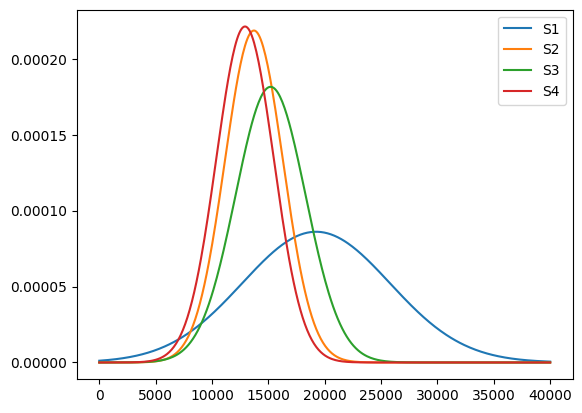

In [144]:
plt.plot(x, curve1, label='S1')
plt.plot(x, curve2, label='S2')
plt.plot(x, curve3, label='S3')
plt.plot(x, curve4, label='S4')
plt.legend()

In [126]:
m1, std1 = fit_gaussian(np.array(dist_s1))
g2 = fit_gaussian(np.array(dist_s2))
g3 = fit_gaussian(np.array(dist_s3))
g4 = fit_gaussian(np.array(dist_s4))

# New background substraction method feeding an array calculated with mode of video

In [3]:
def find_background_mode(video_path, verbose=True, skip=1):
    if verbose:
        print('Loading video...')
    video = cv2.VideoCapture(video_path)
    N_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video.set(1, 0)
    _, frame = video.read()
    if verbose:
        print('Finding background...')
    counts = np.zeros((frame.shape[0], frame.shape[1], 256)) # Only works for 8-bit videos
    video.set(1, 0)
    if skip > 1:
        N_selected = int(N_frames / skip)
        selected_frames = np.linspace(0, N_frames, N_selected, endpoint=False).astype('int')
        for i in tqdm(selected_frames, file=sys.stdout):
            video.set(1, i)
            _, frame = video.read()
            counts = update_counts(counts, frame[:, :, 0].astype(np.uint8))
    else:
        for _ in tqdm(range(1, N_frames), file=sys.stdout):
            _, frame = video.read()
            counts = update_counts(counts, frame[:, :, 0])
    video.release()
    background = np.argmax(counts, axis=2).astype(np.uint8)
    if verbose:
        print('Done! \n')
    return background

@njit
def update_counts(counts, frame):
    for i in range(counts.shape[0]):
        for j in range(counts.shape[1]):
            counts[i, j, frame[i, j]] = counts[i, j, frame[i,j]] + 1
    return counts

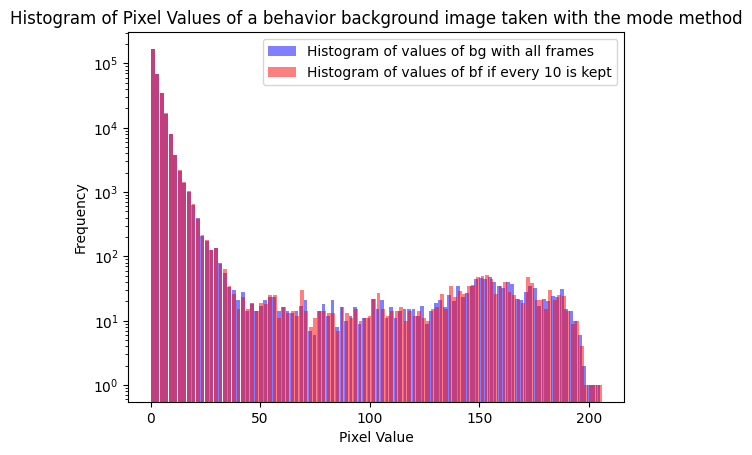

In [67]:
# Plot both histograms on the same plot with a logarithmic y-axis
plt.hist(a_flat, bins=100, color='blue', alpha=0.5, rwidth=0.85, label='Histogram of values of bg with all frames')
plt.hist(b_flat, bins=100, color='red', alpha=0.5, rwidth=0.85, label='Histogram of values of bf if every 10 is kept')
plt.title('Histogram of Pixel Values of a behavior background image taken with the mode method')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.legend()  # Add a legend to differentiate between 'a' and 'b'
plt.show()

In [11]:
import numpy as np
import cv2

def substract_background_with_array(video_path, background):
    
    video_path += "/video.avi"
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open input video file.")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    video_name = os.path.split(video_path)[1]
    output_video_path = os.path.join(os.path.dirname(video_path), "bg_sub_" + video_name)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height), isColor=False)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        background_substracted_frame = cv2.absdiff(frame_gray, background)
        blurred_bsf = cv2.GaussianBlur(background_substracted_frame, (3, 3), 1)

        out.write(blurred_bsf)

    cap.release()
    out.release()
    print(f"Output video saved to {output_video_path}")

In [6]:
def save_mask_depth(dataset_path):
    # Paths
    mask_path = dataset_path + "/mask_video.tif"
    depth_path = dataset_path + "/cropped_depth.avi"
    
    # Opening data
    depth_cap = cv2.VideoCapture(depth_path)
    if not depth_cap.isOpened():
        print("Error: Could not open depth video file.")
        return
    
    fps = int(depth_cap.get(cv2.CAP_PROP_FPS))
    width = int(depth_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(depth_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(depth_cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Prepare video writer to save the output
    out = cv2.VideoWriter(dataset_path + '/depth_mask.avi', cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
    
    # Read the mask video using tifffile
    with tiff.TiffFile(mask_path) as tif:
        # Get the number of frames in the mask video
        n_frames = len(tif.pages)
        
        # Check if total_frames matches n_frames
        if total_frames != n_frames:
            print("Error: mask and depth videos don't have matching frame number.")
            return
        
        # Process each frame
        for i in tqdm(range(total_frames)):
            mask_frame = tif.pages[i].asarray()
            ret, depth_frame = depth_cap.read()
            depth_frame = depth_frame[:,:,0]
            
            
            if not ret:
                print("Error: Could not read frame from depth video.")
                break
            
            # Combine mask and depth frames
            combined_frame = cv2.multiply(mask_frame, depth_frame)
            combined_frame = cv2.cvtColor(combined_frame, cv2.COLOR_GRAY2BGR)
            
            # Write the combined frame to the output video file
            out.write(combined_frame)
            
    # Release the video writer and capture objects
    out.release()
    depth_cap.release()
    print("Processing complete. Result saved as 'depth_mask.avi' in dataset path.")

In [156]:
path = "/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1"

In [145]:
save_mask_depth(path)

  0%|          | 0/17980 [00:00<?, ?it/s]

Processing complete. Result saved as 'depth_mask.avi' in dataset path.


In [7]:
def obtain_depth(dataset_path, mean = 80, edges = 15):
    
    def mean_within_range(array, lower_bound, upper_bound):
        # Create a mask for values within the specified range
        range_mask = (array >= lower_bound) & (array <= upper_bound)

        # Calculate the mean of values within the range
        if np.any(range_mask):
            mean_value = array[range_mask].mean()
        else:
            mean_value = np.nan
         # Use NaN to indicate an empty slice
        return mean_value
    
    depth_mask_path = dataset_path + "/depth_mask.avi"
    # Opening data
    cap = cv2.VideoCapture(depth_mask_path)
    if not cap.isOpened():
        print("Error: Could not open depth video file.")
        return
    
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    lower_bound = mean-edges
    upper_bound = mean+edges
    
    # Process each frame
    mean_values = np.zeros(total_frames)
    last_value = None
    for i in tqdm(range(total_frames)):
        ret, frame = cap.read()
        frame = frame[:,:,0]
        
        # Create a mask for values within the specified range
        range_mask = (frame >= lower_bound) & (frame <= upper_bound)

        # Calculate the mean of values within the range
        if np.any(range_mask):
            mean_value = frame[range_mask].mean()
            last_value = mean_value
        else:
            mean_value = last_value
        
        mean_values[i] = mean_value
        
    
    return mean_values

In [8]:
from scipy.ndimage import gaussian_filter1d, median_filter

In [202]:
depth_values = obtain_depth(path)

  0%|          | 0/17979 [00:00<?, ?it/s]

In [205]:
#med_filt = median_filter(depth_values, 101)
gauss_filt = gaussian_filter1d(depth_values, 5)

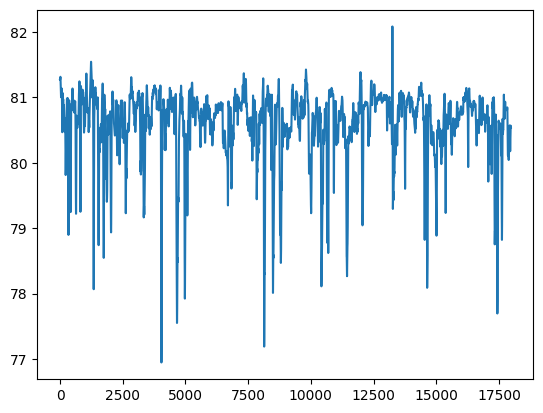

In [206]:
plt.plot(gauss_filt)
plt.show()

In [ ]:
for i in range(len(dataset_list)):
    save_mask_depth(dataset_list)


In [10]:
import pickle

def save_dict(file_path, data_dict):
    """
    Serialize and save a dictionary to a file using pickle.

    Args:
        file_path (str): The file path where the dictionary will be saved.
        data_dict (dict): The dictionary to be saved.
    """
    with open(file_path, 'wb') as file:
        pickle.dump(data_dict, file)
        
def load_dict(file_path):
    """
    Load a dictionary from a file saved using pickle.

    Args:
        file_path (str): The file path of the saved dictionary.

    Returns:
        dict: The loaded dictionary.
    """
    with open(file_path, 'rb') as file:
        loaded_dict = pickle.load(file)
    return loaded_dict

In [ ]:
for i in tqdm(range(len(dataset_list))):
    
    #save_mask_depth(dataset_list[i])
    
    data_dict = {}
    mask_path = dataset_list[i] + "/mask_video.tif"
    
    xy_centroids = compute_centroids(mask_path)
    filt_x_centroids = median_filter(xy_centroids[:,0], 21)
    filt_y_centroids = median_filter(xy_centroids[:,1], 21)
    z_values = obtain_depth(dataset_list[i])
    filt_z_values = gaussian_filter1d(z_values, 5)
    
    xyz_centroids = np.zeros((xy_centroids.shape[0], xy_centroids.shape[1] + 1))
    xyz_centroids[:,0] = filt_x_centroids
    xyz_centroids[:,1] = filt_y_centroids
    xyz_centroids[:,2] = filt_z_values
    
    data_dict['coordinates'] = xyz_centroids
    
    # Specify the file path where you want to save the dictionary
    file_path = dataset_list[i] + '/metadata.pkl'

    save_dict(file_path, data_dict)

In [141]:
depth_values.shape

(17979,)

In [37]:
for i in range(len(dataset_list)):
    dictio = load_dict(dataset_list[i] + "/metadata.pkl")
    xyz = dictio['coordinates']

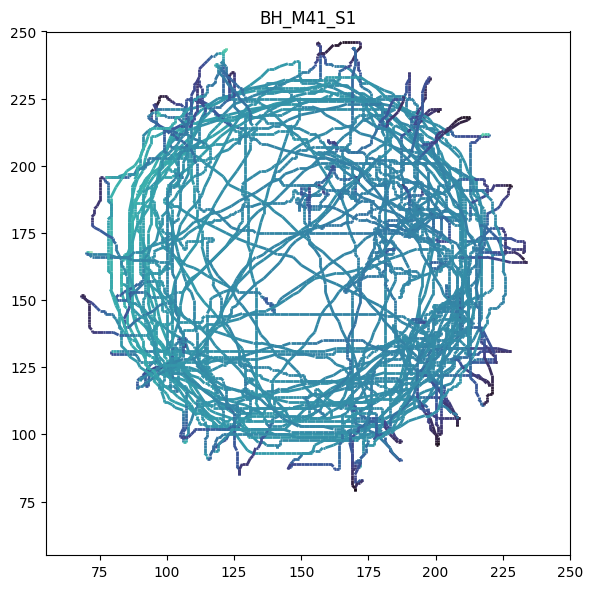

0.39098429679870605


In [71]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection

# Assuming load_dict and dataset_list are defined
t0 = time.time()
# Use only the first dataset
dataset = dataset_list[11]

fig, ax = plt.subplots(figsize=(6, 6))

dictio = load_dict(dataset + "/metadata.pkl")
xyz = dictio['coordinates']
z = xyz[:,2]  # Assuming this is the corresponding 3rd dimension data

# Create a Seaborn palette and convert it to a colormap
n_colors = 256  # Adjust the number of colors
palette = sns.color_palette("mako", n_colors)
cmap = mcolors.ListedColormap(palette)
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

# Prepare line segments and colors
points = np.array([xyz[:-1, 0], xyz[:-1, 1]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
colors = cmap(norm(z[:-1]))

# Create a LineCollection
lc = LineCollection(segments, colors=colors, linewidth=2)

ax.add_collection(lc)
ax.autoscale()
ax.set_xlim([55, 250])
ax.set_ylim([55, 250])
ax.set_aspect('equal', adjustable='box')
ax.set_title("{}".format(dataset.split('/')[-1]))

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()
t1 = time.time()
print(t1-t0)

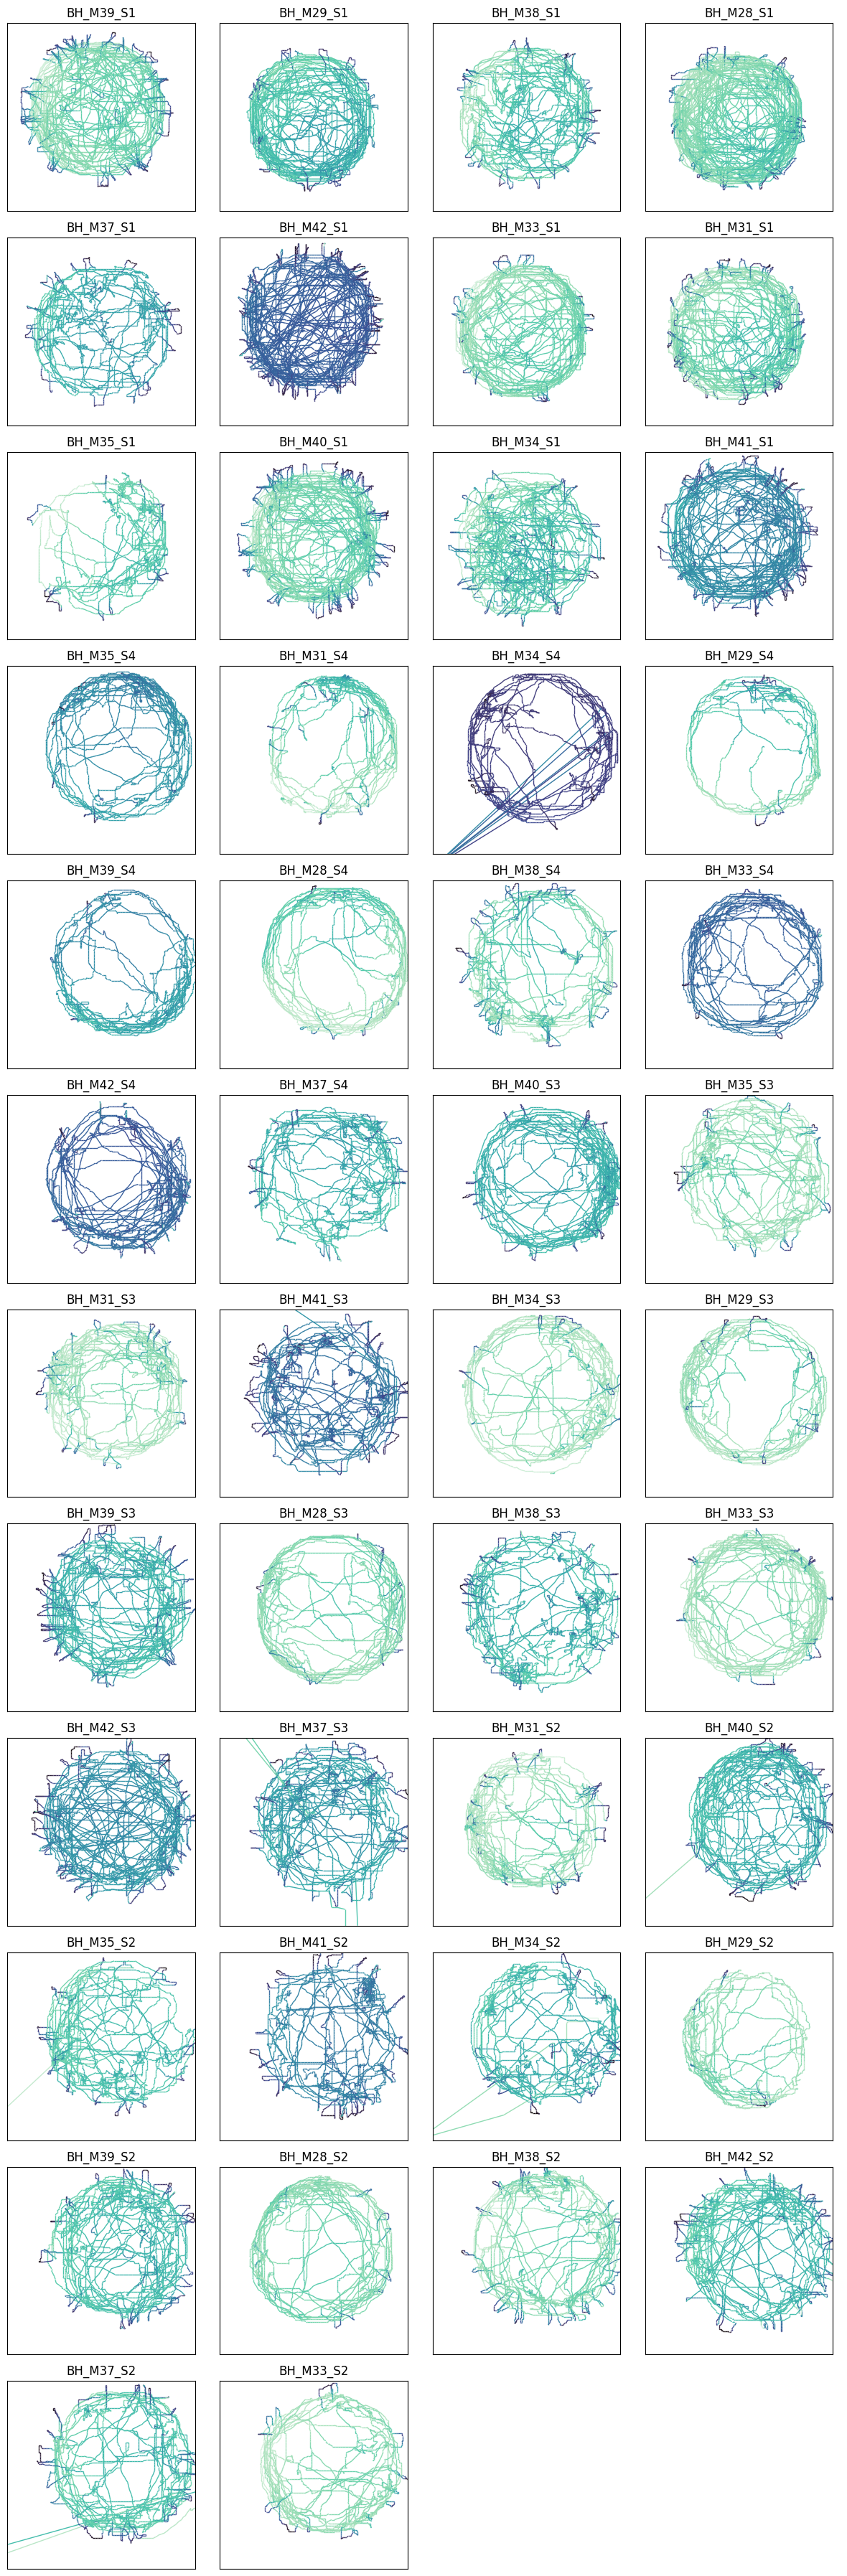

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection

# Assuming load_dict and dataset_list are defined

n_plots = len(dataset_list)
n_cols = 4
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, dataset in enumerate(dataset_list):
    ax = axes[i]

    dictio = load_dict(dataset + "/metadata.pkl")
    xyz = dictio['coordinates']
    z = xyz[:,2]  # Assuming this is the corresponding 3rd dimension data

    # Create a Seaborn palette and convert it to a colormap
    n_colors = 256  # Adjust the number of colors
    palette = sns.color_palette("mako", n_colors)
    cmap = mcolors.ListedColormap(palette)
    norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

    # Prepare line segments and colors
    points = np.array([xyz[:-1, 0], xyz[:-1, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    colors = cmap(norm(z[:-1]))

    # Create a LineCollection
    lc = LineCollection(segments, colors=colors, linewidth=1)

    ax.add_collection(lc)
    #ax.autoscale()
    ax.set_xlim([55, 250])
    ax.set_ylim([55, 250])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("{}".format(dataset.split('/')[-1]))

# Hide any unused axes
for ax in axes[n_plots:]:
    ax.axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

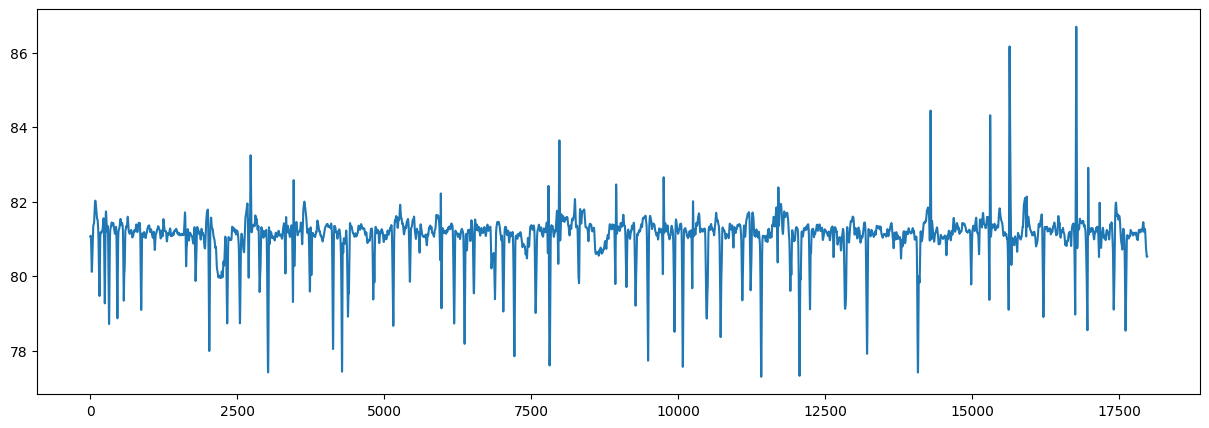

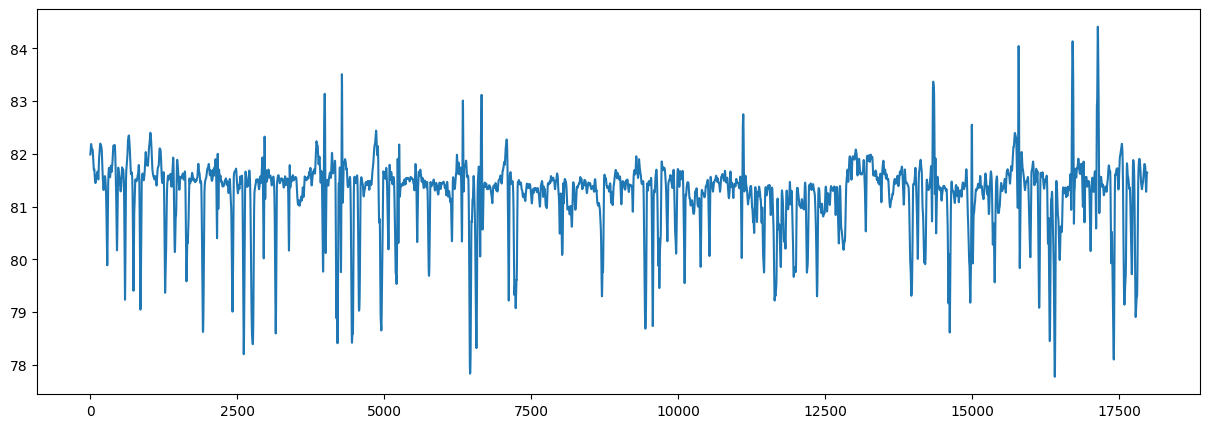

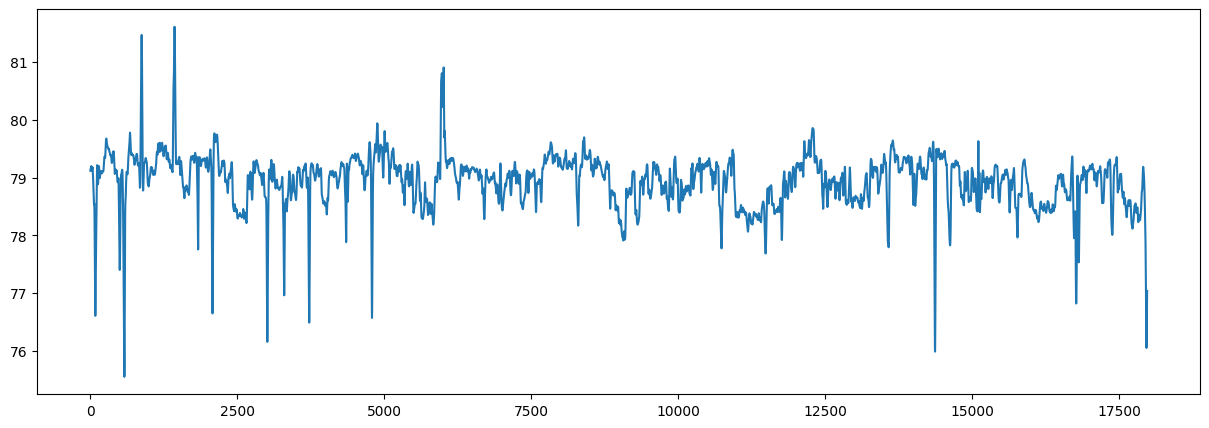

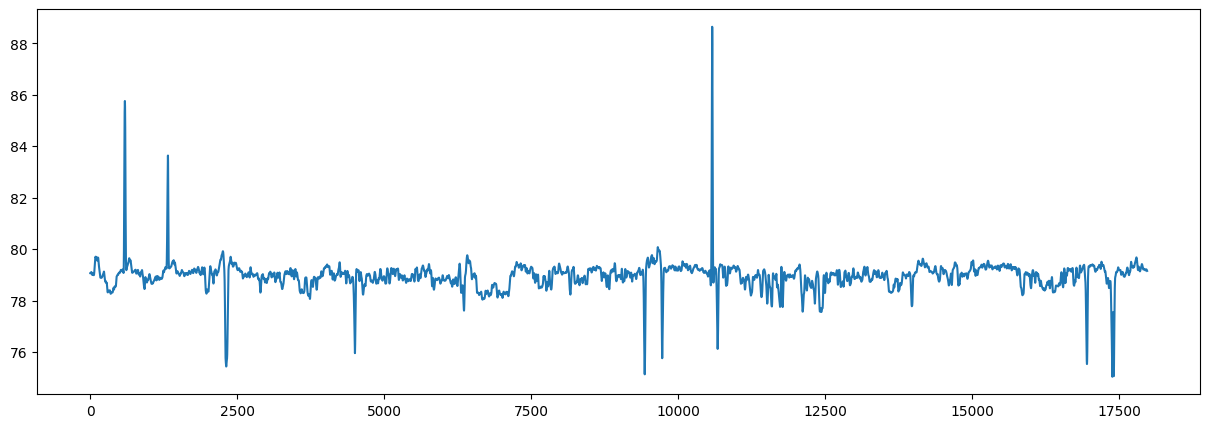

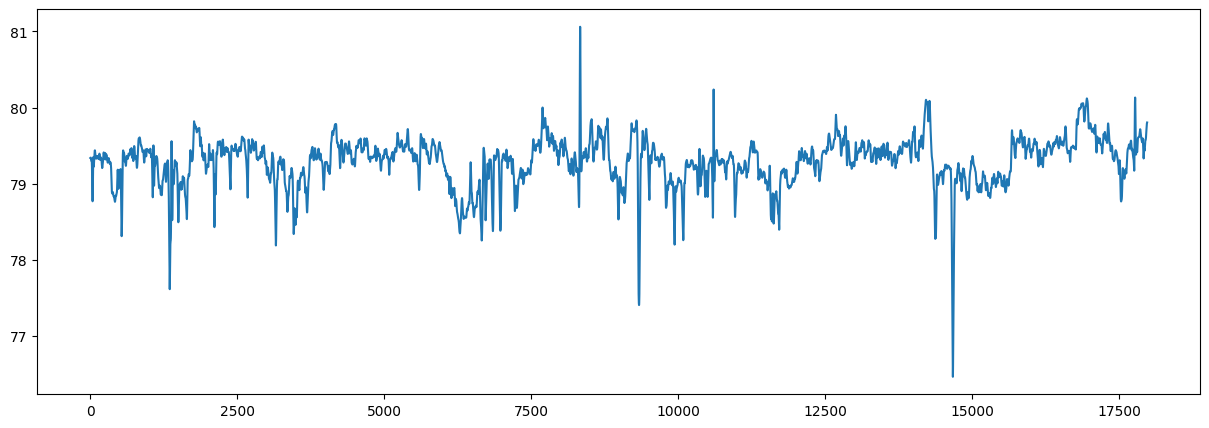

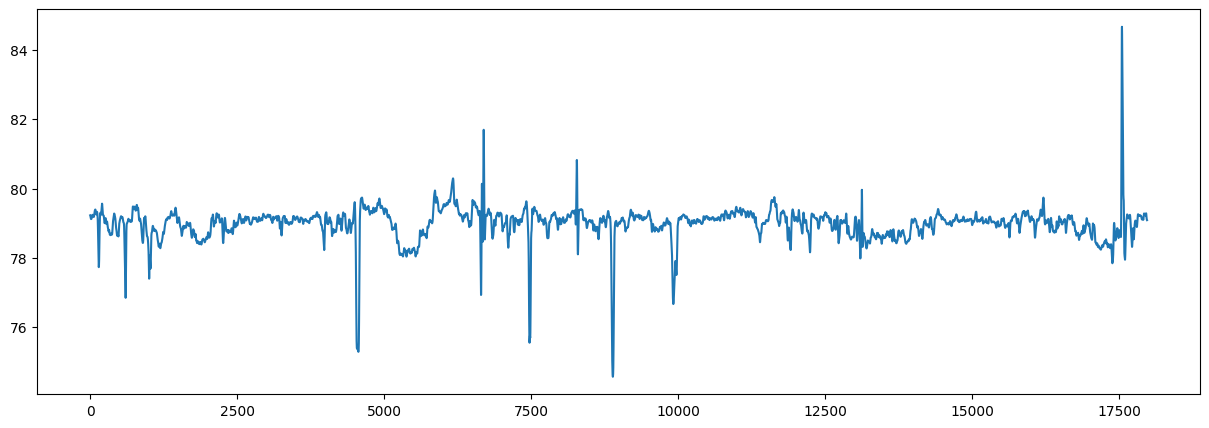

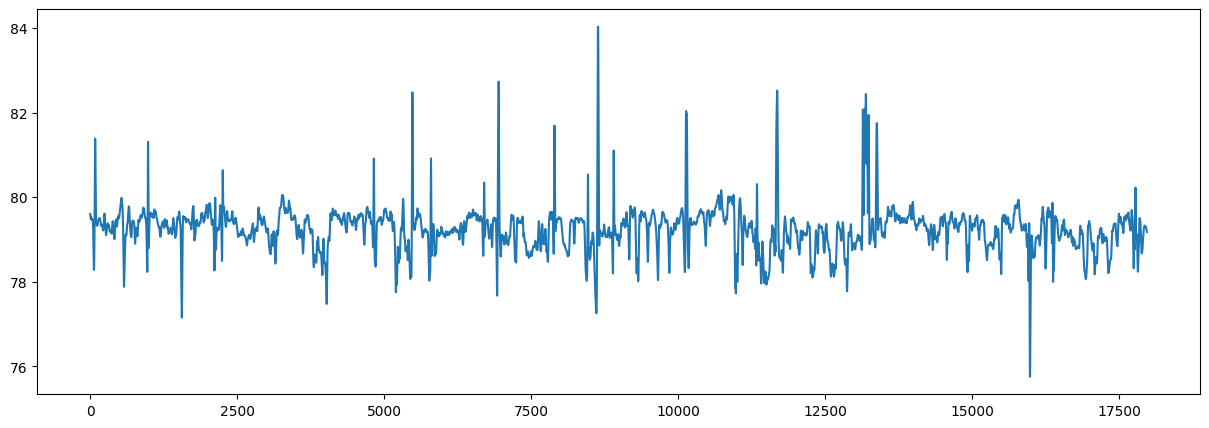

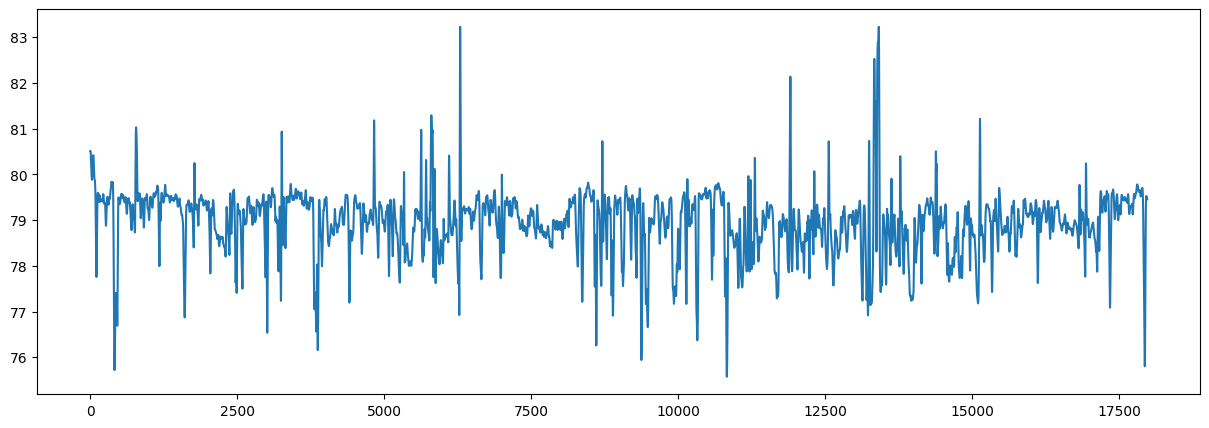

In [83]:
for i in [5, 11, 12, 14, 16, 19, 20, 25]:
    zpath = dataset_list[i] + "/metadata.pkl"
    z = load_dict(zpath)['coordinates'][:,2]
    plt.figure(figsize=(15,5))
    plt.plot(z)
    plt.show()

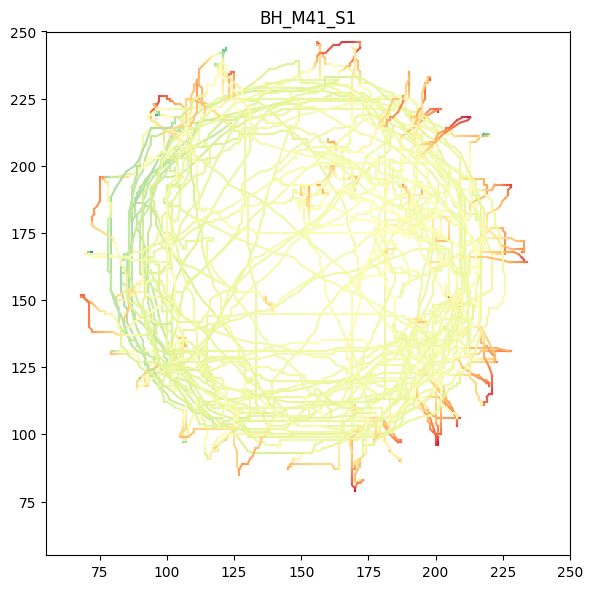

15.510632991790771


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import time

t0 = time.time()
# Assuming load_dict and dataset_list are defined, and you have a third_dimension_array

# Use only the first dataset
dataset = dataset_list[11]

fig, ax = plt.subplots(figsize=(6, 6))

dictio = load_dict(dataset + "/metadata.pkl")
xyz = dictio['coordinates']
z = xyz[:,2]  # Assuming this is the corresponding 3rd dimension data

# Create a Seaborn palette and convert it to a colormap
n_colors = 256  # You can adjust the number of colors
palette = sns.color_palette("Spectral", n_colors)
cmap = mcolors.ListedColormap(palette)
norm = mcolors.Normalize(vmin=np.min(z), vmax=np.max(z))

# Color each segment of the line based on the third dimension value
for j in range(xyz.shape[0] - 1):
    x = xyz[j:j+2, 0]
    y = xyz[j:j+2, 1]
    color = cmap(norm(z[j]))
    ax.plot(x, y, color=color)

ax.set_xlim([55, 250])
ax.set_ylim([55, 250])
ax.set_aspect('equal', adjustable='box')
ax.set_title("{}".format(dataset.split('/')[-1]))

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
t1 = time.time()
print(t1-t0)

In [15]:
from hmmlearn import hmm
import numpy as np

# Assuming data is a NumPy array of shape (n_samples, 3) where columns are x, y, z
data = a["coordinates"]

# Define an HMM with Gaussian emissions
model = hmm.GaussianHMM(n_components=number_of_states, covariance_type="full")

# Fit the model
model.fit(data)

# Predict states
hidden_states = model.predict(data)

NameError: name 'a' is not defined

In [81]:
dataset_list[5]

'/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1'

# Ok let's adress problems in the code:

1. First, (x,y) signals still have abberations. (x,y) goes out of frame because of disapearance of mask.

2. For (z), sometimes the mask only gets abberation values when there's a low count of pixels that are not 0 or 255. It sometimes gets under the floor.

In [6]:
# to modify obtain_depth

def get_floor(dataset_path):
    return None

# Pipeline description:

In [151]:
a = load_dict('/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M34_S4/metadata.pkl')

In [152]:
array = a['coordinates']

In [153]:
x,y = array[:,0], array[:,1]

In [154]:
diff_x, diff_y = np.diff(array[:,0]), np.diff(array[:,1])

In [155]:
diff_x.dtype

dtype('float64')

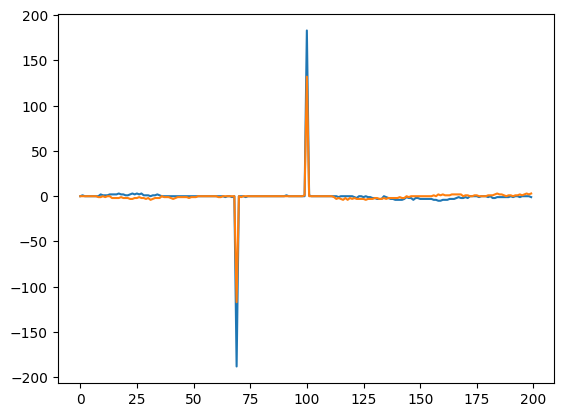

In [157]:
plt.plot(diff_x[500:700])
plt.plot(diff_y[500:700])
plt.show()

In [204]:
def find_and_interpolate_outliers(coordinates_dict, threshold=20):
    
    # Create a copy of the coordinates to avoid modifying the original array
    coords = np.copy(coordinates_dict['coordinates'])
    
    def find_outliers(coordinates_dict, threshold=threshold):
        coords = coordinates_dict['coordinates']
        x, y = coords[:, 0], coords[:, 1]
        diff_x, diff_y = np.diff(x), np.diff(y)
        
        ind_x_pos, ind_x_neg = np.where(diff_x > threshold)[0], np.where(diff_x < -1*threshold)[0]
        ind_y_pos, ind_y_neg = np.where(diff_y > threshold)[0], np.where(diff_y < -1*threshold)[0]


        if len(ind_x_pos) != len(ind_x_neg):
            raise ValueError("Error: positive/negative x indices do not match")
        if len(ind_y_pos) != len(ind_y_neg):
            raise ValueError("Error: positive/negative y indices do not match")

        if len(ind_x_pos) >= len(ind_y_pos):
            ind_x_pos_2d = ind_x_pos.reshape(1, -1)
            ind_x_neg_2d = ind_x_neg.reshape(1, -1)
            ind_array = np.concatenate([ind_x_pos_2d, ind_x_neg_2d], axis=0)
            outlier_duration = np.abs(np.diff(ind_array, axis=0)).reshape(-1)
            outlier_start = np.min(ind_array, axis=0)
            
        elif len(ind_y_pos) > len(ind_x_pos):
            ind_y_pos_2d = ind_y_pos.reshape(1, -1)
            ind_y_neg_2d = ind_y_neg.reshape(1, -1)
            ind_array = np.concatenate([ind_y_pos_2d, ind_y_neg_2d], axis=0)
            outlier_duration = np.abs(np.diff(ind_array, axis=0)).reshape(-1)
            outlier_start = np.min(ind_array, axis=0)
            
        else:
            return [], []

        return outlier_start, outlier_duration

    try:
        outlier_starts, outlier_durations = find_outliers(coordinates_dict, threshold)
    except ValueError as e:
        print(e)
        return coords


    for start, duration in zip(outlier_starts, outlier_durations):
        end = start + duration

        if start > 0 and end < len(coords):
            
            num_points = end - start + 1
            x_interp = np.linspace(coords[start, 0], coords[end + 2, 0], num_points)
            y_interp = np.linspace(coords[start, 1], coords[end + 2, 1], num_points)

            # Replace coordinates in the outlier region
            print(coords[start:end, 0])
            print(x_interp[1:])
            print(coords[start:end, 1])
            print(y_interp[1:])
            coords[start+1:end+1, 0] = x_interp[1:]
            coords[start+1:end+1, 1] = y_interp[1:]

    return coords

In [205]:
b = find_and_interpolate_outliers(a)

[244.  56.  56.  56.  56.  55.  55.  55.  55.  55.  55.  55.  55.  55.
  55.  55.  55.  55.  55.  55.  55.  55.  55.  56.  56.  56.  56.  56.
  56.  56.  56.]
[243.87096774 243.74193548 243.61290323 243.48387097 243.35483871
 243.22580645 243.09677419 242.96774194 242.83870968 242.70967742
 242.58064516 242.4516129  242.32258065 242.19354839 242.06451613
 241.93548387 241.80645161 241.67741935 241.5483871  241.41935484
 241.29032258 241.16129032 241.03225806 240.90322581 240.77419355
 240.64516129 240.51612903 240.38709677 240.25806452 240.12903226
 240.        ]
[158.  41.  41.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.  40.
  40.  40.  40.]
[158.48387097 158.96774194 159.4516129  159.93548387 160.41935484
 160.90322581 161.38709677 161.87096774 162.35483871 162.83870968
 163.32258065 163.80645161 164.29032258 164.77419355 165.25806452
 165.74193548 166.22580645 166.70967742 167.19354839 167.67741935
 168.16

NameError: name 'a' is not defined

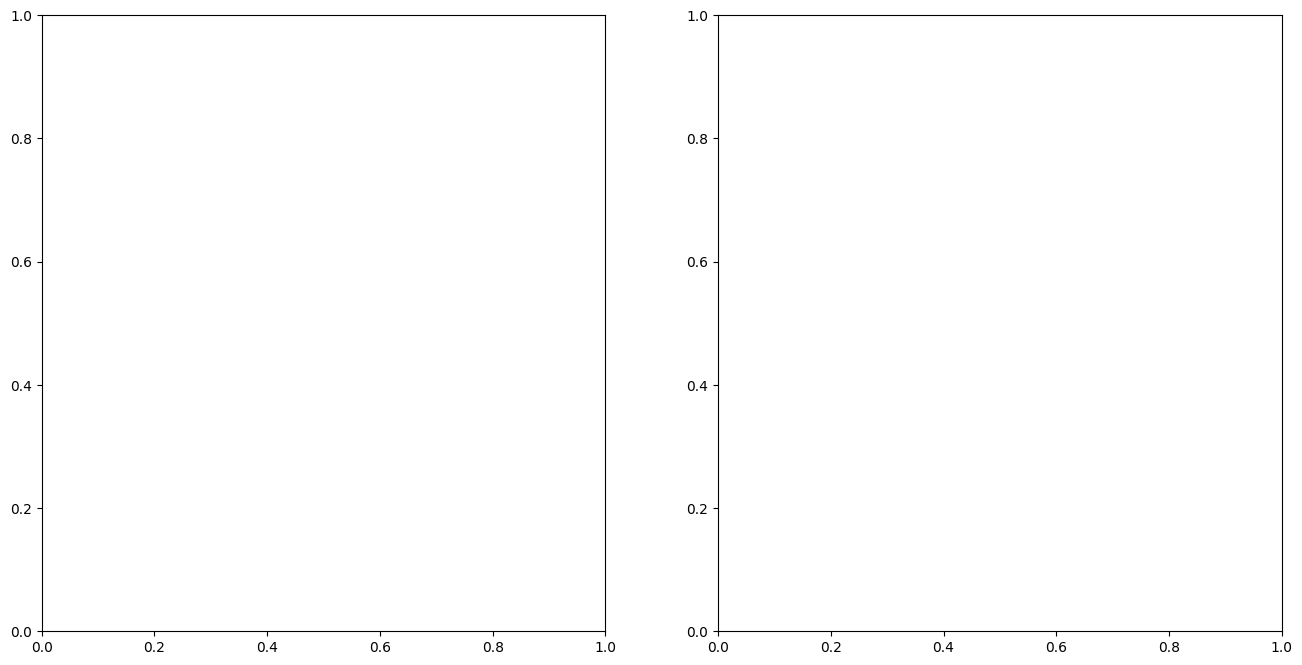

In [16]:
fig,ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(a["coordinates"][:,0], a["coordinates"][:,1])
ax[1].plot(b[:,0],b[:,1])
plt.show()

# Complete preprocessing functions and data opening
##### functions put in behavior_functions.py

In [ ]:
def behavior_preprocessing(dataset_list, verbose = False):
    roi = []
    for i in range(len(dataset_list)):

        # Premake rectangles to crop
        roi.append(select_center(dataset_list[i] + "/video.avi", verbose=verbose))

    for i in tqdm(range(len(dataset_list)), desc="Batch processing"):

        # crop (with premade rectangles in coords)
        crop_video_and_depth(dataset_list[i], roi[i], verbose=verbose)

        # Substract background
        find_background_mode(dataset_list[i], verbose = False)
        substract_background_with_array(dataset_list[i], verbose=verbose) 

        # Binarize
        binarize_video(dataset_list[i], verbose=verbose)

        # Saving video mask to use with depth and coords
        save_mask_depth(dataset_list[i],verbose=verbose)

        # Computing centroids
        xy_coords = compute_centroids(dataset_list[i])

        # Obtaining depth for z
        z_coord = obtain_depth(dataset_list[i])

        
        # Filter and combine x,y and z
        x,y,z = gaussian_filter1d(xy_coords[:,0], 20), gaussian_filter1d(xy_coords[:,1], 20), gaussian_filter1d(z_coord, 20)
        z = detrend_linear2d(x,y,z)
        coords = np.column_stack((x, y, z))

        del xy_coords, z_coord, x, y, z

        # saving coordinate dictionary with pickle
        coords_dict = {}
        coords_dict['coords'] = coords

        folderpath = Path(dataset_list[i])
        metadatapath = folderpath.joinpath("metadata.pkl")

        save_dict(str(metadatapath), coords_dict)
        if verbose:
            print('Processing of {} is completed.'.format(str(Path(dataset_list[i]).name)))

    return None

def open_coords(dataset_list, experiment_time = 600, camera_freq = 30):
    
    n_datasets = len(dataset_list)
    coord_stack = np.zeros((experiment_time*camera_freq, 3, n_datasets))
    padding = np.zeros(n_datasets)
    
    for i in range(n_datasets):
        coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
        coord = coord_dict['coords']
        
        # Calculate how much padding is needed
        padding_needed = coord_stack.shape[0] - coord.shape[0]
        padding[i] = padding_needed
        
        if padding_needed > 0:

            # Pad the array with the edge value
            coord_padded = np.pad(coord, ((0, padding_needed), (0, 0)), mode='edge')
            if padding_needed > 50:
                print(dataset_list[i].split('/')[-1] + f" is too short. It's {int(padding[i])} values shorter that normal.")
        
        elif padding_needed < 0:

            # Crops the start of array 
            coord_padded = coord[-padding_needed: , :]
            
        else:

            coord_padded = coord
            
        # Assign the padded coord to the right place in coord_stack
        coord_stack[:, :, i] = coord_padded
        
    return coord_stack, padding